In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [3]:
import supervision as sv

#
# download dataset with a few labelled images (5-10 is recommended, but you can go as high as you like)
#
from roboflow import login,Roboflow

login()
rf = Roboflow()

%cd datasets/
project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

%cd ..

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 3201.47it/s]


/home/andrewhealey/sam-fine-tuning


In [4]:
from persam.load import load_predictor

predictor = load_predictor("vit_t")

from fine_tune.samed import LoRA_Mask_Decoder

# lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=16)
# mask_decoder = lora_mask_decoder.mask_decoder.cuda()
mask_decoder = predictor.model.mask_decoder

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamEverythingDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

from torch.utils.data import ConcatDataset

point_dataset = SamPointDataset(climbing_dataset, predictor, device, points_per_mask = 20)
box_dataset = SamBoxDataset(climbing_dataset, predictor,device)

In [7]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from timm.optim import AdamW

# Define your model and other necessary components here

# Hyperparameters
initial_lr = 2e-4
warmup_steps = 25000
total_steps = 150_000
batch_size = 30 # perform gradient accumulation for this--they do 256 images per batch.
weight_decay = 0.1

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

optimizer = optim.AdamW(predictor.model.mask_decoder.parameters(), lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

In [8]:
curr_dataset = point_dataset
run_grad = True

In [9]:
import torch
from torch import nn
import cv2
from torch.nn.functional import threshold, normalize
from numpy.random import permutation
from tqdm import tqdm

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from torch.nn import functional as F
import json

log_period = 200 # a few batches
wandb_log_period = 20

# lr = 1e-5
# optimizer = torch.optim.Adam(predictor.model.mask_decoder.parameters(), lr=lr)

run = wandb.init(
    # Set the project where this run will be logged
    project="sam-fine-tune",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })


loss_fn = nn.MSELoss()

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

# iter through dataset in random order

while curr_iters < total_steps:
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):
        curr_iters += 1

        decoder_input, (gt_mask, gt_masks), (input_size,original_size) = curr_dataset[idx]

        H,W = gt_mask.shape if gt_mask is not None else gt_masks.shape[1:]

        low_res_masks, iou_predictions = mask_decoder(**decoder_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
        binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[0,:,:,:]

        gt_binary_mask, binary_mask, iou, pred_idx = get_max_iou_masks(gt_mask,gt_masks,binary_masks)
        pred_iou = iou_predictions[0,pred_idx]
        pred_mask = high_res_masks[pred_idx]

        assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
        h,w = gt_binary_mask.shape


        flat_pred_mask = pred_mask.view(1,-1)
        flat_gt_binary_mask = gt_binary_mask.view(1,-1)

        focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
        dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)

        # mse loss between predicted and real IoU
        mse_loss = loss_fn(pred_iou, iou)

        loss = 20*focal_loss + dice_loss + mse_loss

        recent_losses += [loss.item()]
        recent_losses = recent_losses[-log_period:]

        if i % wandb_log_period == 0:
            wandb.log({
                "loss": loss.cpu().item(),
                "focal_loss": focal_loss.cpu().item(),
                "dice_loss": dice_loss.cpu().item(),
                "mse_loss": mse_loss.cpu().item(),
            })

        if i % log_period == 0:
            print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

        if not run_grad: continue
        accumulated_loss += loss
        if curr_iters % batch_size == 0:
            optimizer.zero_grad()
            accumulated_loss /= batch_size
            accumulated_loss.backward()
            optimizer.step()
            accumulated_loss = 0
        
        warmup_scheduler.step(curr_iters)

        # Set learning rate for the step-wise decay phase
        lr_decay_scheduler.step(curr_iters)


  0%|          | 0/56498 [00:00<?, ?it/s]Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  0%|          | 3/56498 [00:01<7:31:00,  2.09it/s] 

Loss: 0.480651319026947


  0%|          | 203/56498 [00:19<1:11:18, 13.16it/s]

Loss: 0.3387923564761877


  1%|          | 403/56498 [00:36<1:16:07, 12.28it/s]

Loss: 0.2697657324746251


  1%|          | 603/56498 [00:54<1:44:03,  8.95it/s]

Loss: 0.2747479172423482


  1%|▏         | 803/56498 [01:11<1:09:41, 13.32it/s]

Loss: 0.25989944180473684


  2%|▏         | 1003/56498 [01:28<1:15:02, 12.32it/s]

Loss: 0.22311444987542928


  2%|▏         | 1203/56498 [01:46<1:44:50,  8.79it/s]

Loss: 0.23707507128827274


  2%|▏         | 1403/56498 [02:03<1:09:56, 13.13it/s]

Loss: 0.23748886946588754


  3%|▎         | 1603/56498 [02:20<1:14:20, 12.31it/s]

Loss: 0.21349631691351534


  3%|▎         | 1803/56498 [02:38<1:43:46,  8.78it/s]

Loss: 0.2635171950981021


  4%|▎         | 2003/56498 [02:55<1:09:13, 13.12it/s]

Loss: 0.21303869370371104


  4%|▍         | 2203/56498 [03:13<1:13:18, 12.34it/s]

Loss: 0.22688126742839812


  4%|▍         | 2403/56498 [03:30<1:43:43,  8.69it/s]

Loss: 0.27466326095163823


  5%|▍         | 2603/56498 [03:48<1:06:33, 13.50it/s]

Loss: 0.21867180049419402


  5%|▍         | 2803/56498 [04:05<1:14:31, 12.01it/s]

Loss: 0.1938229788839817


  5%|▌         | 3003/56498 [04:23<1:41:35,  8.78it/s]

Loss: 0.23789980713278056


  6%|▌         | 3203/56498 [04:40<1:06:09, 13.43it/s]

Loss: 0.23465374568477274


  6%|▌         | 3403/56498 [04:57<1:11:30, 12.37it/s]

Loss: 0.23187495416030288


  6%|▋         | 3603/56498 [05:15<1:39:34,  8.85it/s]

Loss: 0.2475969278253615


  7%|▋         | 3803/56498 [05:32<1:06:26, 13.22it/s]

Loss: 0.21741344260051845


  7%|▋         | 4003/56498 [05:49<1:10:55, 12.33it/s]

Loss: 0.21720302976667882


  7%|▋         | 4203/56498 [06:07<1:39:58,  8.72it/s]

Loss: 0.21401349537074565


  8%|▊         | 4403/56498 [06:24<1:06:26, 13.07it/s]

Loss: 0.22967061273753642


  8%|▊         | 4603/56498 [06:42<1:11:16, 12.13it/s]

Loss: 0.2176125595252961


  9%|▊         | 4803/56498 [06:59<1:37:54,  8.80it/s]

Loss: 0.21074388900771737


  9%|▉         | 5003/56498 [07:16<1:04:13, 13.36it/s]

Loss: 0.22705706756561994


  9%|▉         | 5203/56498 [07:34<1:09:29, 12.30it/s]

Loss: 0.2515111989155412


 10%|▉         | 5403/56498 [07:52<1:37:29,  8.74it/s]

Loss: 0.2117929982021451


 10%|▉         | 5603/56498 [08:09<1:04:30, 13.15it/s]

Loss: 0.19617319244891404


 10%|█         | 5803/56498 [08:26<1:07:35, 12.50it/s]

Loss: 0.1937949719466269


 11%|█         | 6003/56498 [08:44<1:39:29,  8.46it/s]

Loss: 0.21354537237435578


 11%|█         | 6203/56498 [09:01<1:03:43, 13.15it/s]

Loss: 0.22640411930158735


 11%|█▏        | 6403/56498 [09:18<1:07:38, 12.34it/s]

Loss: 0.32547255540266634


 12%|█▏        | 6603/56498 [09:36<1:32:56,  8.95it/s]

Loss: 0.21441685929894447


 12%|█▏        | 6803/56498 [09:53<1:01:56, 13.37it/s]

Loss: 0.22229057190939783


 12%|█▏        | 7003/56498 [10:10<1:07:02, 12.30it/s]

Loss: 0.1972049962170422


 13%|█▎        | 7203/56498 [10:28<1:31:07,  9.02it/s]

Loss: 0.23105755291879176


 13%|█▎        | 7403/56498 [10:45<1:03:33, 12.88it/s]

Loss: 0.24529818853363394


 13%|█▎        | 7603/56498 [11:02<1:06:19, 12.29it/s]

Loss: 0.18439036609604956


 14%|█▍        | 7803/56498 [11:20<1:29:24,  9.08it/s]

Loss: 0.2077378357760608


 14%|█▍        | 8003/56498 [11:37<1:02:11, 13.00it/s]

Loss: 0.20021773962303996


 15%|█▍        | 8203/56498 [11:55<1:05:01, 12.38it/s]

Loss: 0.21145331963896752


 15%|█▍        | 8403/56498 [12:12<1:29:10,  8.99it/s]

Loss: 0.19052361238747836


 15%|█▌        | 8603/56498 [12:29<59:48, 13.35it/s]  

Loss: 0.19927381061948835


 16%|█▌        | 8803/56498 [12:47<1:04:43, 12.28it/s]

Loss: 0.1972387833148241


 16%|█▌        | 9003/56498 [13:04<1:28:36,  8.93it/s]

Loss: 0.20537078950554133


 16%|█▋        | 9203/56498 [13:21<58:56, 13.37it/s]  

Loss: 0.2059525434859097


 17%|█▋        | 9403/56498 [13:39<1:03:27, 12.37it/s]

Loss: 0.18624970776960253


 17%|█▋        | 9603/56498 [13:56<1:27:44,  8.91it/s]

Loss: 0.19471328328363596


 17%|█▋        | 9803/56498 [14:13<58:25, 13.32it/s]  

Loss: 0.18722059071063996


 18%|█▊        | 10003/56498 [14:30<1:03:16, 12.25it/s]

Loss: 0.17309362288564445


 18%|█▊        | 10203/56498 [14:48<1:25:10,  9.06it/s]

Loss: 0.20786363497376442


 18%|█▊        | 10403/56498 [15:05<58:08, 13.21it/s]  

Loss: 0.23282323464751242


 19%|█▉        | 10603/56498 [15:23<1:01:50, 12.37it/s]

Loss: 0.18699437173083425


 19%|█▉        | 10803/56498 [15:40<1:25:29,  8.91it/s]

Loss: 0.1965880988817662


 19%|█▉        | 11003/56498 [15:57<57:34, 13.17it/s]  

Loss: 0.1946150585822761


 20%|█▉        | 11203/56498 [16:15<1:01:14, 12.33it/s]

Loss: 0.21561681732535362


 20%|██        | 11403/56498 [16:32<1:23:03,  9.05it/s]

Loss: 0.20276963090524078


 21%|██        | 11603/56498 [16:49<56:06, 13.34it/s]  

Loss: 0.23514951525256036


 21%|██        | 11803/56498 [17:07<59:40, 12.48it/s]  

Loss: 0.2030764629691839


 21%|██        | 12003/56498 [17:24<1:24:07,  8.82it/s]

Loss: 0.20104733129031957


 22%|██▏       | 12203/56498 [17:41<55:26, 13.32it/s]  

Loss: 0.19087258460000156


 22%|██▏       | 12403/56498 [17:59<59:02, 12.45it/s]  

Loss: 0.20244807608425616


 22%|██▏       | 12603/56498 [18:16<1:24:15,  8.68it/s]

Loss: 0.18510828332975507


 23%|██▎       | 12803/56498 [18:33<54:31, 13.36it/s]  

Loss: 0.17753984020091593


 23%|██▎       | 13003/56498 [18:51<58:34, 12.38it/s]  

Loss: 0.2258021396584809


 23%|██▎       | 13203/56498 [19:08<1:22:33,  8.74it/s]

Loss: 0.18206164824776352


 24%|██▎       | 13403/56498 [19:25<54:33, 13.16it/s]  

Loss: 0.20484824385493994


 24%|██▍       | 13603/56498 [19:43<1:00:03, 11.90it/s]

Loss: 0.19100458320230246


 24%|██▍       | 13803/56498 [20:00<1:20:42,  8.82it/s]

Loss: 0.22775575775653123


 25%|██▍       | 14003/56498 [20:17<53:48, 13.16it/s]  

Loss: 0.20234890265390276


 25%|██▌       | 14203/56498 [20:35<57:26, 12.27it/s]  

Loss: 0.17765167606994509


 25%|██▌       | 14403/56498 [20:53<1:19:48,  8.79it/s]

Loss: 0.2602213749848306


 26%|██▌       | 14603/56498 [21:10<53:21, 13.08it/s]  

Loss: 0.19908286336809397


 26%|██▌       | 14803/56498 [21:27<56:16, 12.35it/s]  

Loss: 0.2300629537925124


 27%|██▋       | 15003/56498 [21:45<1:24:00,  8.23it/s]

Loss: 0.20339153418317438


 27%|██▋       | 15203/56498 [22:02<51:52, 13.27it/s]  

Loss: 0.19608717741444706


 27%|██▋       | 15403/56498 [22:19<56:07, 12.20it/s]  

Loss: 0.1634679565951228


 28%|██▊       | 15603/56498 [22:36<1:16:31,  8.91it/s]

Loss: 0.18787898706272244


 28%|██▊       | 15803/56498 [22:54<51:20, 13.21it/s]  

Loss: 0.2121605243999511


 28%|██▊       | 16003/56498 [23:11<55:04, 12.26it/s]  

Loss: 0.23568054899573326


 29%|██▊       | 16203/56498 [23:29<1:15:27,  8.90it/s]

Loss: 0.2361116610467434


 29%|██▉       | 16403/56498 [23:46<50:45, 13.17it/s]  

Loss: 0.2021260885335505


 29%|██▉       | 16603/56498 [24:03<53:42, 12.38it/s]  

Loss: 0.17970900340005755


 30%|██▉       | 16803/56498 [24:21<1:14:39,  8.86it/s]

Loss: 0.21004558481276037


 30%|███       | 17003/56498 [24:38<49:00, 13.43it/s]  

Loss: 0.20566945273429155


 30%|███       | 17203/56498 [24:55<52:38, 12.44it/s]  

Loss: 0.2076342447847128


 31%|███       | 17403/56498 [25:12<1:12:54,  8.94it/s]

Loss: 0.18336096761748194


 31%|███       | 17603/56498 [25:30<48:23, 13.40it/s]  

Loss: 0.204208058770746


 32%|███▏      | 17803/56498 [25:47<52:07, 12.37it/s]  

Loss: 0.21104271825402976


 32%|███▏      | 18003/56498 [26:04<1:11:56,  8.92it/s]

Loss: 0.20229160580784084


 32%|███▏      | 18203/56498 [26:21<48:05, 13.27it/s]  

Loss: 0.20782282611355185


 33%|███▎      | 18403/56498 [26:39<51:15, 12.39it/s]  

Loss: 0.19544070854783058


 33%|███▎      | 18603/56498 [26:56<1:11:45,  8.80it/s]

Loss: 0.21562870047986507


 33%|███▎      | 18803/56498 [27:13<46:50, 13.41it/s]  

Loss: 0.18797001468017696


 34%|███▎      | 19003/56498 [27:31<50:56, 12.27it/s]  

Loss: 0.1949734766408801


 34%|███▍      | 19203/56498 [27:48<1:09:15,  8.97it/s]

Loss: 0.1762250039167702


 34%|███▍      | 19403/56498 [28:05<46:38, 13.26it/s]  

Loss: 0.18592153958976268


 35%|███▍      | 19603/56498 [28:23<52:23, 11.74it/s]  

Loss: 0.19234311392530798


 35%|███▌      | 19803/56498 [28:42<1:09:50,  8.76it/s]

Loss: 0.17975715089589359


 35%|███▌      | 20003/56498 [28:59<45:41, 13.31it/s]  

Loss: 0.1919193036388606


 36%|███▌      | 20203/56498 [29:17<48:26, 12.49it/s]  

Loss: 0.18867454873397946


 36%|███▌      | 20403/56498 [29:34<1:06:04,  9.10it/s]

Loss: 0.18764491830952465


 36%|███▋      | 20603/56498 [29:51<45:29, 13.15it/s]  

Loss: 0.19407729383558034


 37%|███▋      | 20803/56498 [30:09<50:18, 11.83it/s]  

Loss: 0.17000149100087583


 37%|███▋      | 21003/56498 [30:26<1:09:04,  8.56it/s]

Loss: 0.1808741706982255


 38%|███▊      | 21203/56498 [30:43<48:48, 12.05it/s]  

Loss: 0.19504639668390156


 38%|███▊      | 21403/56498 [31:00<47:16, 12.37it/s]  

Loss: 0.18038760725408792


 38%|███▊      | 21603/56498 [31:18<1:04:34,  9.01it/s]

Loss: 0.2273884289432317


 39%|███▊      | 21803/56498 [31:35<43:32, 13.28it/s]  

Loss: 0.1915682821162045


 39%|███▉      | 22003/56498 [31:52<46:27, 12.37it/s]  

Loss: 0.20754530401900412


 39%|███▉      | 22203/56498 [32:10<1:03:52,  8.95it/s]

Loss: 0.23201782729476692


 40%|███▉      | 22403/56498 [32:27<43:03, 13.20it/s]  

Loss: 0.26595257464796307


 40%|████      | 22603/56498 [32:44<51:03, 11.06it/s]  

Loss: 0.23505894539877772


 40%|████      | 22803/56498 [33:01<1:04:13,  8.74it/s]

Loss: 0.21836611157283187


 41%|████      | 23003/56498 [33:19<42:32, 13.12it/s]  

Loss: 0.18405462233349681


 41%|████      | 23203/56498 [33:36<44:33, 12.45it/s]  

Loss: 0.21816659655421972


 41%|████▏     | 23403/56498 [33:53<1:01:51,  8.92it/s]

Loss: 0.21942242274060844


 42%|████▏     | 23603/56498 [34:10<41:11, 13.31it/s]  

Loss: 0.2113861548528075


 42%|████▏     | 23803/56498 [34:28<43:33, 12.51it/s]  

Loss: 0.2265923443250358


 42%|████▏     | 24003/56498 [34:45<1:03:07,  8.58it/s]

Loss: 0.19541814612224698


 43%|████▎     | 24203/56498 [35:02<40:55, 13.15it/s]  

Loss: 0.1828980644233525


 43%|████▎     | 24403/56498 [35:20<43:38, 12.26it/s]  

Loss: 0.2003557624761015


 44%|████▎     | 24603/56498 [35:37<59:22,  8.95it/s]  

Loss: 0.1665355054102838


 44%|████▍     | 24803/56498 [35:54<39:34, 13.35it/s]  

Loss: 0.167803208027035


 44%|████▍     | 25003/56498 [36:11<44:22, 11.83it/s]  

Loss: 0.21206590358167887


 45%|████▍     | 25203/56498 [36:29<57:49,  9.02it/s]  

Loss: 0.1859832987561822


 45%|████▍     | 25403/56498 [36:46<39:58, 12.96it/s]  

Loss: 0.1825272295810282


 45%|████▌     | 25603/56498 [37:03<41:42, 12.35it/s]  

Loss: 0.18665989350527526


 46%|████▌     | 25803/56498 [37:21<56:45,  9.01it/s]  

Loss: 0.17946145633235575


 46%|████▌     | 26003/56498 [37:37<37:54, 13.41it/s]  

Loss: 0.1640672599710524


 46%|████▋     | 26203/56498 [37:55<40:41, 12.41it/s]  

Loss: 0.1907134367339313


 47%|████▋     | 26403/56498 [38:12<55:52,  8.98it/s]  

Loss: 0.20649049676954745


 47%|████▋     | 26603/56498 [38:29<37:24, 13.32it/s]  

Loss: 0.2485615162178874


 47%|████▋     | 26803/56498 [38:47<40:36, 12.19it/s]  

Loss: 0.20087134024128317


 48%|████▊     | 27003/56498 [39:04<54:23,  9.04it/s]  

Loss: 0.19465201895684003


 48%|████▊     | 27203/56498 [39:21<36:27, 13.39it/s]  

Loss: 0.17731100138276815


 49%|████▊     | 27403/56498 [39:38<39:12, 12.37it/s]  

Loss: 0.17441535025835037


 49%|████▉     | 27603/56498 [39:55<52:46,  9.12it/s]  

Loss: 0.17881906228139996


 49%|████▉     | 27803/56498 [40:12<35:36, 13.43it/s]  

Loss: 0.25536830984055997


 50%|████▉     | 28003/56498 [40:30<38:02, 12.48it/s]  

Loss: 0.1974995695054531


 50%|████▉     | 28203/56498 [40:47<52:48,  8.93it/s]  

Loss: 0.19108706498518585


 50%|█████     | 28403/56498 [41:04<35:08, 13.32it/s]

Loss: 0.20238239565864205


 51%|█████     | 28603/56498 [41:21<37:31, 12.39it/s]

Loss: 0.19162925159558652


 51%|█████     | 28803/56498 [41:38<51:41,  8.93it/s]

Loss: 0.1747004868090153


 51%|█████▏    | 29003/56498 [41:55<33:47, 13.56it/s]  

Loss: 0.19164617789909244


 52%|█████▏    | 29203/56498 [42:13<36:52, 12.34it/s]

Loss: 0.18412610829807818


 52%|█████▏    | 29403/56498 [42:30<49:49,  9.06it/s]

Loss: 0.20078449431806802


 52%|█████▏    | 29603/56498 [42:47<33:33, 13.36it/s]  

Loss: 0.17141017272137105


 53%|█████▎    | 29803/56498 [43:04<35:42, 12.46it/s]

Loss: 0.1728838424757123


 53%|█████▎    | 30003/56498 [43:21<48:55,  9.02it/s]

Loss: 0.1681023677624762


 53%|█████▎    | 30203/56498 [43:38<32:43, 13.39it/s]

Loss: 0.16845583910122514


 54%|█████▍    | 30403/56498 [43:56<34:41, 12.53it/s]  

Loss: 0.15563738014549017


 54%|█████▍    | 30603/56498 [44:13<47:30,  9.08it/s]

Loss: 0.1528058126755059


 55%|█████▍    | 30803/56498 [44:30<31:40, 13.52it/s]

Loss: 0.17833477944135667


 55%|█████▍    | 31003/56498 [44:47<33:58, 12.51it/s]

Loss: 0.20573429878801108


 55%|█████▌    | 31203/56498 [45:05<47:17,  8.91it/s]

Loss: 0.17170518427155912


 56%|█████▌    | 31403/56498 [45:21<31:01, 13.48it/s]

Loss: 0.18360534213483334


 56%|█████▌    | 31603/56498 [45:39<33:14, 12.48it/s]

Loss: 0.17418864917010068


 56%|█████▋    | 31803/56498 [45:56<45:10,  9.11it/s]

Loss: 0.15960196036845445


 57%|█████▋    | 32003/56498 [46:13<30:40, 13.31it/s]

Loss: 0.1761078448407352


 57%|█████▋    | 32203/56498 [46:30<33:06, 12.23it/s]

Loss: 0.1648443314153701


 57%|█████▋    | 32403/56498 [46:48<44:15,  9.07it/s]

Loss: 0.16882593135349452


 58%|█████▊    | 32603/56498 [47:04<29:55, 13.31it/s]

Loss: 0.18878248002380132


 58%|█████▊    | 32803/56498 [47:22<31:25, 12.57it/s]

Loss: 0.19315154876559973


 58%|█████▊    | 33003/56498 [47:39<43:24,  9.02it/s]

Loss: 0.2255464238487184


 59%|█████▉    | 33203/56498 [47:56<28:58, 13.40it/s]

Loss: 0.17338066977448763


 59%|█████▉    | 33403/56498 [48:13<31:32, 12.20it/s]

Loss: 0.18088140627369284


 59%|█████▉    | 33603/56498 [48:31<42:26,  8.99it/s]

Loss: 0.18126280521973967


 60%|█████▉    | 33803/56498 [48:48<28:28, 13.28it/s]

Loss: 0.1832707018777728


 60%|██████    | 34003/56498 [49:05<30:48, 12.17it/s]

Loss: 0.2010371159389615


 61%|██████    | 34203/56498 [49:22<41:07,  9.04it/s]

Loss: 0.19613338686525822


 61%|██████    | 34403/56498 [49:39<27:59, 13.16it/s]

Loss: 0.2023397152684629


 61%|██████    | 34603/56498 [49:56<28:54, 12.62it/s]

Loss: 0.16099704804364592


 62%|██████▏   | 34803/56498 [50:13<40:44,  8.87it/s]

Loss: 0.17019593061879276


 62%|██████▏   | 35003/56498 [50:30<26:48, 13.36it/s]

Loss: 0.18149233281612395


 62%|██████▏   | 35203/56498 [50:47<28:29, 12.46it/s]

Loss: 0.19323188465088606


 63%|██████▎   | 35403/56498 [51:05<38:29,  9.13it/s]

Loss: 0.18153159701265395


 63%|██████▎   | 35603/56498 [51:22<26:06, 13.34it/s]

Loss: 0.1855047691054642


 63%|██████▎   | 35803/56498 [51:39<27:51, 12.38it/s]

Loss: 0.18150562692433594


 64%|██████▎   | 36003/56498 [51:56<37:36,  9.08it/s]

Loss: 0.15653513208031655


 64%|██████▍   | 36203/56498 [52:13<25:06, 13.47it/s]

Loss: 0.1580112623795867


 64%|██████▍   | 36403/56498 [52:30<26:43, 12.53it/s]

Loss: 0.17838036742061378


 65%|██████▍   | 36603/56498 [52:48<36:42,  9.03it/s]

Loss: 0.1945376405864954


 65%|██████▌   | 36803/56498 [53:05<24:47, 13.24it/s]

Loss: 0.1798853277415037


 65%|██████▌   | 37003/56498 [53:22<26:09, 12.42it/s]

Loss: 0.1579455048404634


 66%|██████▌   | 37203/56498 [53:39<35:58,  8.94it/s]

Loss: 0.1741649867594242


 66%|██████▌   | 37403/56498 [53:56<23:39, 13.45it/s]

Loss: 0.16083530800417065


 67%|██████▋   | 37603/56498 [54:13<25:20, 12.43it/s]

Loss: 0.18940231791697443


 67%|██████▋   | 37803/56498 [54:31<35:33,  8.76it/s]

Loss: 0.18819610541686416


 67%|██████▋   | 38003/56498 [54:48<23:13, 13.28it/s]

Loss: 0.1980427200719714


 68%|██████▊   | 38203/56498 [55:05<24:34, 12.41it/s]

Loss: 0.15649430582299828


 68%|██████▊   | 38403/56498 [55:22<33:16,  9.06it/s]

Loss: 0.20659197529777884


 68%|██████▊   | 38603/56498 [55:39<22:21, 13.34it/s]

Loss: 0.18311109041795134


 69%|██████▊   | 38803/56498 [55:57<24:02, 12.27it/s]

Loss: 0.17103040372952819


 69%|██████▉   | 39003/56498 [56:14<32:25,  8.99it/s]

Loss: 0.16280603289604187


 69%|██████▉   | 39203/56498 [56:31<21:25, 13.45it/s]

Loss: 0.2064662780612707


 70%|██████▉   | 39403/56498 [56:48<22:52, 12.46it/s]

Loss: 0.16037533823400735


 70%|███████   | 39603/56498 [57:05<31:31,  8.93it/s]

Loss: 0.1712255644891411


 70%|███████   | 39803/56498 [57:22<20:37, 13.50it/s]

Loss: 0.15316886611282826


 71%|███████   | 40003/56498 [57:40<21:48, 12.60it/s]

Loss: 0.1742746414244175


 71%|███████   | 40203/56498 [57:57<29:50,  9.10it/s]

Loss: 0.2246067612618208


 72%|███████▏  | 40403/56498 [58:14<21:15, 12.62it/s]

Loss: 0.2029096365533769


 72%|███████▏  | 40603/56498 [58:32<22:22, 11.84it/s]

Loss: 0.19773966182023286


 72%|███████▏  | 40803/56498 [58:50<28:58,  9.03it/s]

Loss: 0.1755339390411973


 73%|███████▎  | 41003/56498 [59:07<19:09, 13.48it/s]

Loss: 0.1726548670604825


 73%|███████▎  | 41203/56498 [59:24<20:38, 12.35it/s]

Loss: 0.18408845813013613


 73%|███████▎  | 41403/56498 [59:42<27:46,  9.06it/s]

Loss: 0.1821123795583844


 74%|███████▎  | 41603/56498 [59:58<18:45, 13.24it/s]

Loss: 0.17284272849559784


 74%|███████▍  | 41803/56498 [1:00:16<20:09, 12.15it/s]

Loss: 0.15586986518464982


 74%|███████▍  | 42003/56498 [1:00:33<26:54,  8.98it/s]

Loss: 0.1619345008023083


 75%|███████▍  | 42203/56498 [1:00:50<17:34, 13.56it/s]

Loss: 0.16234665439464152


 75%|███████▌  | 42403/56498 [1:01:07<18:43, 12.55it/s]

Loss: 0.18993797952309252


 75%|███████▌  | 42603/56498 [1:01:24<25:37,  9.04it/s]

Loss: 0.22081594475544988


 76%|███████▌  | 42803/56498 [1:01:41<17:00, 13.42it/s]

Loss: 0.1698281354084611


 76%|███████▌  | 43003/56498 [1:01:59<17:55, 12.54it/s]

Loss: 0.16224367707967757


 76%|███████▋  | 43203/56498 [1:02:16<24:25,  9.07it/s]

Loss: 0.1806047561392188


 77%|███████▋  | 43403/56498 [1:02:33<16:11, 13.48it/s]

Loss: 0.1622791955154389


 77%|███████▋  | 43603/56498 [1:02:50<17:00, 12.63it/s]

Loss: 0.15949752090498806


 78%|███████▊  | 43803/56498 [1:03:07<23:07,  9.15it/s]

Loss: 0.16276168391108514


 78%|███████▊  | 44003/56498 [1:03:24<15:37, 13.33it/s]

Loss: 0.1579182700626552


 78%|███████▊  | 44203/56498 [1:03:41<16:17, 12.57it/s]

Loss: 0.17105523531325162


 79%|███████▊  | 44403/56498 [1:03:58<22:24,  9.00it/s]

Loss: 0.1625611376389861


 79%|███████▉  | 44603/56498 [1:04:15<14:46, 13.42it/s]

Loss: 0.1560689947474748


 79%|███████▉  | 44803/56498 [1:04:32<15:57, 12.21it/s]

Loss: 0.1577667148038745


 80%|███████▉  | 45003/56498 [1:04:50<21:14,  9.02it/s]

Loss: 0.1743161484785378


 80%|████████  | 45203/56498 [1:05:07<14:11, 13.26it/s]

Loss: 0.1698553561978042


 80%|████████  | 45403/56498 [1:05:24<14:47, 12.50it/s]

Loss: 0.18913046330213545


 81%|████████  | 45603/56498 [1:05:41<20:06,  9.03it/s]

Loss: 0.18765634912997484


 81%|████████  | 45803/56498 [1:05:58<13:17, 13.41it/s]

Loss: 0.16957929737865926


 81%|████████▏ | 46003/56498 [1:06:16<13:58, 12.52it/s]

Loss: 0.17793074924498797


 82%|████████▏ | 46203/56498 [1:06:33<19:03,  9.00it/s]

Loss: 0.16124937737360598


 82%|████████▏ | 46403/56498 [1:06:50<12:32, 13.41it/s]

Loss: 0.18323548970744014


 82%|████████▏ | 46603/56498 [1:07:07<13:18, 12.39it/s]

Loss: 0.16381016310304403


 83%|████████▎ | 46803/56498 [1:07:24<17:39,  9.15it/s]

Loss: 0.16728493247181178


 83%|████████▎ | 47003/56498 [1:07:41<11:56, 13.26it/s]

Loss: 0.1645326458849013


 84%|████████▎ | 47203/56498 [1:07:59<12:18, 12.59it/s]

Loss: 0.17331832953728735


 84%|████████▍ | 47403/56498 [1:08:16<16:30,  9.18it/s]

Loss: 0.1610099472850561


 84%|████████▍ | 47603/56498 [1:08:33<11:05, 13.37it/s]

Loss: 0.15294050097465514


 85%|████████▍ | 47803/56498 [1:08:50<11:33, 12.55it/s]

Loss: 0.15053089048713444


 85%|████████▍ | 48003/56498 [1:09:07<15:49,  8.95it/s]

Loss: 0.18833345937542617


 85%|████████▌ | 48203/56498 [1:09:24<10:16, 13.46it/s]

Loss: 0.1651518345810473


 86%|████████▌ | 48403/56498 [1:09:41<10:53, 12.39it/s]

Loss: 0.17973265707492828


 86%|████████▌ | 48603/56498 [1:09:59<14:38,  8.98it/s]

Loss: 0.176883557876572


 86%|████████▋ | 48803/56498 [1:10:16<09:31, 13.47it/s]

Loss: 0.1552716109715402


 87%|████████▋ | 49003/56498 [1:10:33<09:58, 12.52it/s]

Loss: 0.15271243777126073


 87%|████████▋ | 49203/56498 [1:10:50<13:23,  9.08it/s]

Loss: 0.15804975613951683


 87%|████████▋ | 49403/56498 [1:11:07<08:54, 13.28it/s]

Loss: 0.1437522361241281


 88%|████████▊ | 49603/56498 [1:11:24<09:10, 12.53it/s]

Loss: 0.15887980885803699


 88%|████████▊ | 49803/56498 [1:11:42<12:26,  8.97it/s]

Loss: 0.17184232985600828


 89%|████████▊ | 50003/56498 [1:11:59<08:06, 13.35it/s]

Loss: 0.1663009294308722


 89%|████████▉ | 50203/56498 [1:12:16<08:25, 12.45it/s]

Loss: 0.1689417941123247


 89%|████████▉ | 50403/56498 [1:12:33<11:16,  9.00it/s]

Loss: 0.15800387002527713


 90%|████████▉ | 50603/56498 [1:12:50<07:14, 13.58it/s]

Loss: 0.14499907618388533


 90%|████████▉ | 50803/56498 [1:13:07<07:37, 12.46it/s]

Loss: 0.15707906493917106


 90%|█████████ | 51003/56498 [1:13:24<10:07,  9.05it/s]

Loss: 0.16364088688045741


 91%|█████████ | 51203/56498 [1:13:41<06:33, 13.46it/s]

Loss: 0.2093045313563198


 91%|█████████ | 51403/56498 [1:13:58<06:45, 12.57it/s]

Loss: 0.1698169775120914


 91%|█████████▏| 51603/56498 [1:14:16<09:03,  9.01it/s]

Loss: 0.16445312355645


 92%|█████████▏| 51803/56498 [1:14:32<05:46, 13.54it/s]

Loss: 0.16593472238630055


 92%|█████████▏| 52003/56498 [1:14:50<06:01, 12.44it/s]

Loss: 0.16131707228720188


 92%|█████████▏| 52203/56498 [1:15:07<08:10,  8.75it/s]

Loss: 0.16985548948869109


 93%|█████████▎| 52403/56498 [1:15:24<05:06, 13.34it/s]

Loss: 0.15562596015632152


 93%|█████████▎| 52603/56498 [1:15:41<05:14, 12.37it/s]

Loss: 0.18135799842886627


 93%|█████████▎| 52803/56498 [1:15:59<06:43,  9.16it/s]

Loss: 0.16494345353916287


 94%|█████████▍| 53003/56498 [1:16:15<04:20, 13.43it/s]

Loss: 0.15018853932619095


 94%|█████████▍| 53203/56498 [1:16:33<04:26, 12.39it/s]

Loss: 0.16267801010981203


 95%|█████████▍| 53403/56498 [1:16:50<05:44,  9.00it/s]

Loss: 0.16151863817125559


 95%|█████████▍| 53603/56498 [1:17:07<03:34, 13.48it/s]

Loss: 0.14383656101301312


 95%|█████████▌| 53803/56498 [1:17:24<03:35, 12.52it/s]

Loss: 0.16256438207812607


 96%|█████████▌| 54003/56498 [1:17:41<04:37,  9.00it/s]

Loss: 0.15785776283591985


 96%|█████████▌| 54203/56498 [1:17:58<02:50, 13.46it/s]

Loss: 0.16151495968922971


 96%|█████████▋| 54403/56498 [1:18:15<02:47, 12.48it/s]

Loss: 0.1561669457145035


 97%|█████████▋| 54603/56498 [1:18:32<03:29,  9.05it/s]

Loss: 0.14604447199031712


 97%|█████████▋| 54803/56498 [1:18:49<02:08, 13.21it/s]

Loss: 0.16296143924817444


 97%|█████████▋| 55003/56498 [1:19:07<02:00, 12.41it/s]

Loss: 0.14872508536092938


 98%|█████████▊| 55203/56498 [1:19:24<02:26,  8.85it/s]

Loss: 0.1526132491696626


 98%|█████████▊| 55403/56498 [1:19:41<01:21, 13.38it/s]

Loss: 0.14594621682539582


 98%|█████████▊| 55603/56498 [1:19:58<01:11, 12.45it/s]

Loss: 0.1699072984419763


 99%|█████████▉| 55803/56498 [1:20:15<01:17,  9.01it/s]

Loss: 0.13255047203972936


 99%|█████████▉| 56003/56498 [1:20:32<00:37, 13.36it/s]

Loss: 0.17436776351183653


 99%|█████████▉| 56203/56498 [1:20:50<00:23, 12.55it/s]

Loss: 0.15813082175329327


100%|█████████▉| 56403/56498 [1:21:07<00:10,  9.02it/s]

Loss: 0.16566137876361609


  0%|          | 2/56498 [00:00<1:09:34, 13.54it/s]

Loss: 0.17063199032098056


  0%|          | 200/56498 [00:16<1:08:55, 13.61it/s]

Loss: 0.14806730665266513


  1%|          | 402/56498 [00:34<1:09:51, 13.38it/s]

Loss: 0.15962701723445208


  1%|          | 602/56498 [00:51<1:17:27, 12.03it/s]

Loss: 0.15123767202720045


  1%|▏         | 800/56498 [01:08<1:08:19, 13.59it/s]

Loss: 0.15497678220272065


  2%|▏         | 1002/56498 [01:25<1:09:21, 13.33it/s]

Loss: 0.14405779952183365


  2%|▏         | 1202/56498 [01:43<1:17:28, 11.90it/s]

Loss: 0.14507893847301603


  2%|▏         | 1400/56498 [02:00<1:07:43, 13.56it/s]

Loss: 0.14364536799490452


  3%|▎         | 1602/56498 [02:17<1:08:49, 13.29it/s]

Loss: 0.1483345645107329


  3%|▎         | 1802/56498 [02:34<1:14:57, 12.16it/s]

Loss: 0.1406467179208994


  4%|▎         | 2000/56498 [02:51<1:06:46, 13.60it/s]

Loss: 0.1794535863213241


  4%|▍         | 2202/56498 [03:08<1:09:04, 13.10it/s]

Loss: 0.1664138974621892


  4%|▍         | 2402/56498 [03:26<1:14:43, 12.06it/s]

Loss: 0.1417115339823067


  5%|▍         | 2600/56498 [03:42<1:06:39, 13.48it/s]

Loss: 0.15493789075873793


  5%|▍         | 2802/56498 [04:00<1:06:42, 13.42it/s]

Loss: 0.1560693447291851


  5%|▌         | 3002/56498 [04:17<1:14:23, 11.98it/s]

Loss: 0.14735801363363862


  6%|▌         | 3200/56498 [04:34<1:05:25, 13.58it/s]

Loss: 0.1462142666336149


  6%|▌         | 3402/56498 [04:51<1:07:11, 13.17it/s]

Loss: 0.17488068887963892


  6%|▋         | 3602/56498 [05:08<1:12:00, 12.24it/s]

Loss: 0.15203657118603586


  7%|▋         | 3800/56498 [05:25<1:04:47, 13.56it/s]

Loss: 0.15304264375939966


  7%|▋         | 4002/56498 [05:43<1:05:21, 13.39it/s]

Loss: 0.1586116807255894


  7%|▋         | 4202/56498 [06:00<1:12:33, 12.01it/s]

Loss: 0.15379718005657195


  8%|▊         | 4400/56498 [06:17<1:04:02, 13.56it/s]

Loss: 0.1491796351596713


  8%|▊         | 4602/56498 [06:34<1:04:55, 13.32it/s]

Loss: 0.14844869934022425


  8%|▊         | 4802/56498 [06:51<1:11:02, 12.13it/s]

Loss: 0.15024534918367863


  9%|▉         | 5000/56498 [07:09<1:08:08, 12.60it/s]

Loss: 0.17622989024966956


  9%|▉         | 5202/56498 [07:28<1:04:45, 13.20it/s]

Loss: 0.13809697015210987


 10%|▉         | 5402/56498 [07:45<1:10:57, 12.00it/s]

Loss: 0.15441193587146698


 10%|▉         | 5600/56498 [08:02<1:02:55, 13.48it/s]

Loss: 0.17284262623637914


 10%|█         | 5802/56498 [08:19<1:03:51, 13.23it/s]

Loss: 0.1429152282141149


 11%|█         | 6002/56498 [08:36<1:09:07, 12.17it/s]

Loss: 0.15519926788285374


 11%|█         | 6200/56498 [08:53<1:02:06, 13.50it/s]

Loss: 0.1660364540107548


 11%|█▏        | 6402/56498 [09:10<1:02:51, 13.28it/s]

Loss: 0.15109102547168732


 12%|█▏        | 6602/56498 [09:28<1:13:04, 11.38it/s]

Loss: 0.15977978682145477


 12%|█▏        | 6800/56498 [09:44<1:01:15, 13.52it/s]

Loss: 0.15002049703150988


 12%|█▏        | 7002/56498 [10:02<1:01:30, 13.41it/s]

Loss: 0.14280828081071376


 13%|█▎        | 7202/56498 [10:19<1:07:14, 12.22it/s]

Loss: 0.14656715219840408


 13%|█▎        | 7400/56498 [10:36<1:00:05, 13.62it/s]

Loss: 0.15691002121195197


 13%|█▎        | 7602/56498 [10:53<1:01:37, 13.23it/s]

Loss: 0.16100500587373973


 14%|█▍        | 7802/56498 [11:10<1:07:08, 12.09it/s]

Loss: 0.16501493737101555


 14%|█▍        | 8000/56498 [11:27<1:03:34, 12.71it/s]

Loss: 0.1444189394451678


 15%|█▍        | 8202/56498 [11:45<1:00:37, 13.28it/s]

Loss: 0.15060623148456215


 15%|█▍        | 8402/56498 [12:02<1:06:11, 12.11it/s]

Loss: 0.15702494571916759


 15%|█▌        | 8600/56498 [12:19<59:14, 13.48it/s]  

Loss: 0.1452472469303757


 16%|█▌        | 8802/56498 [12:37<59:39, 13.32it/s]  

Loss: 0.1652540610730648


 16%|█▌        | 9002/56498 [12:54<1:07:17, 11.76it/s]

Loss: 0.16140519517473875


 16%|█▋        | 9200/56498 [13:11<57:38, 13.68it/s]  

Loss: 0.14280591210350393


 17%|█▋        | 9402/56498 [13:28<1:03:32, 12.35it/s]

Loss: 0.15886835349723696


 17%|█▋        | 9602/56498 [13:45<1:04:15, 12.16it/s]

Loss: 0.14893867881968617


 17%|█▋        | 9800/56498 [14:02<57:24, 13.56it/s]  

Loss: 0.14655825659632682


 18%|█▊        | 10002/56498 [14:19<58:13, 13.31it/s] 

Loss: 0.15012536969035864


 18%|█▊        | 10202/56498 [14:37<1:03:20, 12.18it/s]

Loss: 0.15405734736472368


 18%|█▊        | 10400/56498 [14:53<57:04, 13.46it/s]  

Loss: 0.14540104020386935


 19%|█▉        | 10602/56498 [15:11<57:47, 13.23it/s]  

Loss: 0.15449112626723946


 19%|█▉        | 10802/56498 [15:28<1:05:16, 11.67it/s]

Loss: 0.15356677835807203


 19%|█▉        | 11000/56498 [15:45<56:29, 13.42it/s]  

Loss: 0.14406940829008819


 20%|█▉        | 11202/56498 [16:02<56:13, 13.43it/s]  

Loss: 0.14117109598591923


 20%|██        | 11402/56498 [16:20<1:02:53, 11.95it/s]

Loss: 0.1458466316573322


 21%|██        | 11600/56498 [16:37<54:31, 13.72it/s]  

Loss: 0.18924119969829917


 21%|██        | 11802/56498 [16:54<55:25, 13.44it/s]  

Loss: 0.16081202059984206


 21%|██        | 12002/56498 [17:11<1:01:45, 12.01it/s]

Loss: 0.14697832390666007


 22%|██▏       | 12200/56498 [17:28<57:44, 12.79it/s]  

Loss: 0.13727646301500498


 22%|██▏       | 12402/56498 [17:45<55:40, 13.20it/s]  

Loss: 0.13617808134295045


 22%|██▏       | 12602/56498 [18:03<1:00:49, 12.03it/s]

Loss: 0.12935595085844398


 23%|██▎       | 12800/56498 [18:20<53:33, 13.60it/s]  

Loss: 0.13970170930027961


 23%|██▎       | 13002/56498 [18:37<54:41, 13.26it/s]  

Loss: 0.18636262780055404


 23%|██▎       | 13202/56498 [18:54<59:06, 12.21it/s]  

Loss: 0.1815774086676538


 24%|██▎       | 13400/56498 [19:11<53:14, 13.49it/s]  

Loss: 0.18202442259527743


 24%|██▍       | 13602/56498 [19:28<57:16, 12.48it/s]  

Loss: 0.17194827171042562


 24%|██▍       | 13802/56498 [19:46<1:00:40, 11.73it/s]

Loss: 0.13499813675880432


 25%|██▍       | 14000/56498 [20:02<52:53, 13.39it/s]  

Loss: 0.15547940317541362


 25%|██▌       | 14202/56498 [20:20<53:49, 13.10it/s]  

Loss: 0.17020898608490825


 25%|██▌       | 14402/56498 [20:37<58:42, 11.95it/s]  

Loss: 0.18063182371668518


 26%|██▌       | 14600/56498 [20:54<51:35, 13.54it/s]  

Loss: 0.17562227360904217


 26%|██▌       | 14802/56498 [21:12<52:10, 13.32it/s]  

Loss: 0.1412691650725901


 27%|██▋       | 15002/56498 [21:29<59:46, 11.57it/s]  

Loss: 0.15266415781341494


 27%|██▋       | 15200/56498 [21:46<50:36, 13.60it/s]  

Loss: 0.13893208863213657


 27%|██▋       | 15402/56498 [22:03<51:39, 13.26it/s]  

Loss: 0.15640388892963528


 28%|██▊       | 15602/56498 [22:20<55:58, 12.18it/s]  

Loss: 0.14386550394818187


 28%|██▊       | 15800/56498 [22:37<51:06, 13.27it/s]  

Loss: 0.1582406223192811


 28%|██▊       | 16002/56498 [22:55<50:55, 13.25it/s]  

Loss: 0.15036675019189716


 29%|██▊       | 16202/56498 [23:12<56:19, 11.92it/s]  

Loss: 0.15235385358333586


 29%|██▉       | 16400/56498 [23:29<56:23, 11.85it/s]  

Loss: 0.13363214572891594


 29%|██▉       | 16602/56498 [23:46<49:45, 13.36it/s]  

Loss: 0.16518851961940528


 30%|██▉       | 16802/56498 [24:03<55:02, 12.02it/s]  

Loss: 0.1502317981235683


 30%|███       | 17000/56498 [24:20<49:37, 13.27it/s]  

Loss: 0.1368345564045012


 30%|███       | 17202/56498 [24:38<49:23, 13.26it/s]  

Loss: 0.14035504685714842


 31%|███       | 17402/56498 [24:55<53:40, 12.14it/s]  

Loss: 0.1479239159170538


 31%|███       | 17600/56498 [25:12<48:20, 13.41it/s]  

Loss: 0.1385408539045602


 32%|███▏      | 17802/56498 [25:29<50:29, 12.77it/s]  

Loss: 0.14855268565937876


 32%|███▏      | 18002/56498 [25:46<52:52, 12.13it/s]  

Loss: 0.1443254120927304


 32%|███▏      | 18200/56498 [26:03<47:19, 13.49it/s]  

Loss: 0.14231314312666654


 33%|███▎      | 18402/56498 [26:20<47:19, 13.42it/s]  

Loss: 0.1419708775356412


 33%|███▎      | 18602/56498 [26:38<52:32, 12.02it/s]  

Loss: 0.1776559274084866


 33%|███▎      | 18800/56498 [26:54<45:33, 13.79it/s]  

Loss: 0.1281200593430549


 34%|███▎      | 19002/56498 [27:12<46:36, 13.41it/s]  

Loss: 0.1401050769723952


 34%|███▍      | 19202/56498 [27:29<52:25, 11.86it/s]  

Loss: 0.13996180321089924


 34%|███▍      | 19400/56498 [27:46<45:21, 13.63it/s]  

Loss: 0.13933649959042668


 35%|███▍      | 19602/56498 [28:03<45:28, 13.52it/s]  

Loss: 0.14830148184671998


 35%|███▌      | 19802/56498 [28:20<50:52, 12.02it/s]  

Loss: 0.14466806387528777


 35%|███▌      | 20000/56498 [28:37<45:41, 13.31it/s]  

Loss: 0.13849641412496566


 36%|███▌      | 20202/56498 [28:54<45:00, 13.44it/s]  

Loss: 0.14686687041074037


 36%|███▌      | 20402/56498 [29:11<49:51, 12.07it/s]  

Loss: 0.14105258386582137


 36%|███▋      | 20600/56498 [29:28<47:49, 12.51it/s]  

Loss: 0.14446045964024962


 37%|███▋      | 20802/56498 [29:46<44:37, 13.33it/s]  

Loss: 0.14728278940543532


 37%|███▋      | 21002/56498 [30:03<49:00, 12.07it/s]  

Loss: 0.12494359287433326


 38%|███▊      | 21200/56498 [30:20<43:46, 13.44it/s]  

Loss: 0.15483353167772293


 38%|███▊      | 21402/56498 [30:37<43:31, 13.44it/s]  

Loss: 0.14785230584442616


 38%|███▊      | 21602/56498 [30:54<47:51, 12.15it/s]  

Loss: 0.138306172946468


 39%|███▊      | 21800/56498 [31:11<42:47, 13.51it/s]  

Loss: 0.13933328974060713


 39%|███▉      | 22002/56498 [31:28<44:19, 12.97it/s]  

Loss: 0.1333211537450552


 39%|███▉      | 22202/56498 [31:46<46:52, 12.19it/s]  

Loss: 0.13933350743725895


 40%|███▉      | 22400/56498 [32:02<41:40, 13.64it/s]  

Loss: 0.1500462151877582


 40%|████      | 22602/56498 [32:20<42:44, 13.22it/s]  

Loss: 0.14561773281544446


 40%|████      | 22802/56498 [32:37<46:20, 12.12it/s]  

Loss: 0.16675519704818725


 41%|████      | 23000/56498 [32:54<41:02, 13.60it/s]  

Loss: 0.16725860059261322


 41%|████      | 23202/56498 [33:11<43:04, 12.88it/s]  

Loss: 0.14150346249341964


 41%|████▏     | 23402/56498 [33:28<46:54, 11.76it/s]  

Loss: 0.1606845863070339


 42%|████▏     | 23600/56498 [33:45<40:18, 13.60it/s]  

Loss: 0.14578333439305424


 42%|████▏     | 23802/56498 [34:03<41:05, 13.26it/s]  

Loss: 0.15770273607224225


 42%|████▏     | 24002/56498 [34:20<45:16, 11.96it/s]  

Loss: 0.15022914415225386


 43%|████▎     | 24200/56498 [34:37<39:52, 13.50it/s]  

Loss: 0.1477973248809576


 43%|████▎     | 24402/56498 [34:54<39:50, 13.43it/s]  

Loss: 0.17249779613688587


 44%|████▎     | 24602/56498 [35:11<44:00, 12.08it/s]  

Loss: 0.14583587674424053


 44%|████▍     | 24800/56498 [35:28<41:27, 12.74it/s]  

Loss: 0.14514881076291203


 44%|████▍     | 25002/56498 [35:46<39:54, 13.16it/s]  

Loss: 0.170210972269997


 45%|████▍     | 25202/56498 [36:03<42:47, 12.19it/s]  

Loss: 0.1458108178153634


 45%|████▍     | 25400/56498 [36:20<38:17, 13.53it/s]  

Loss: 0.15090463923290373


 45%|████▌     | 25602/56498 [36:37<38:37, 13.33it/s]  

Loss: 0.15504649240523577


 46%|████▌     | 25802/56498 [36:54<44:53, 11.39it/s]  

Loss: 0.1591138230264187


 46%|████▌     | 26000/56498 [37:12<40:26, 12.57it/s]  

Loss: 0.14421783899888396


 46%|████▋     | 26202/56498 [37:31<37:53, 13.32it/s]  

Loss: 0.14873177545145155


 47%|████▋     | 26402/56498 [37:48<41:42, 12.02it/s]  

Loss: 0.1420113611035049


 47%|████▋     | 26600/56498 [38:04<36:31, 13.64it/s]  

Loss: 0.1304451367817819


 47%|████▋     | 26802/56498 [38:22<37:28, 13.21it/s]  

Loss: 0.1399701009504497


 48%|████▊     | 27002/56498 [38:39<40:39, 12.09it/s]  

Loss: 0.15171511609107255


 48%|████▊     | 27200/56498 [38:56<35:59, 13.56it/s]  

Loss: 0.13198260187637062


 49%|████▊     | 27402/56498 [39:13<36:27, 13.30it/s]  

Loss: 0.18862504921853543


 49%|████▉     | 27602/56498 [39:31<40:49, 11.80it/s]  

Loss: 0.15047332660295068


 49%|████▉     | 27800/56498 [39:47<35:46, 13.37it/s]  

Loss: 0.14520888924598693


 50%|████▉     | 28002/56498 [40:05<35:28, 13.39it/s]  

Loss: 0.15301547529175877


 50%|████▉     | 28202/56498 [40:22<39:02, 12.08it/s]  

Loss: 0.1537182015180588


 50%|█████     | 28400/56498 [40:39<34:52, 13.42it/s]  

Loss: 0.16433764135465026


 51%|█████     | 28602/56498 [40:56<34:58, 13.29it/s]

Loss: 0.17940739430487157


 51%|█████     | 28802/56498 [41:13<38:54, 11.87it/s]

Loss: 0.15332012871280312


 51%|█████▏    | 29000/56498 [41:30<33:48, 13.55it/s]  

Loss: 0.15570328349247575


 52%|█████▏    | 29202/56498 [41:47<34:16, 13.27it/s]

Loss: 0.1505847417190671


 52%|█████▏    | 29402/56498 [42:05<37:28, 12.05it/s]

Loss: 0.15001622593030334


 52%|█████▏    | 29600/56498 [42:21<33:16, 13.47it/s]

Loss: 0.14023334635421633


 53%|█████▎    | 29802/56498 [42:39<33:11, 13.41it/s]

Loss: 0.14746130861341952


 53%|█████▎    | 30002/56498 [42:56<36:20, 12.15it/s]

Loss: 0.1506194899044931


 53%|█████▎    | 30200/56498 [43:13<32:22, 13.54it/s]

Loss: 0.15502638692036272


 54%|█████▍    | 30402/56498 [43:30<33:06, 13.14it/s]

Loss: 0.12727071507833898


 54%|█████▍    | 30602/56498 [43:48<35:50, 12.04it/s]

Loss: 0.15099154809489845


 55%|█████▍    | 30800/56498 [44:04<31:37, 13.55it/s]

Loss: 0.14984290080145002


 55%|█████▍    | 31002/56498 [44:22<31:50, 13.34it/s]

Loss: 0.15411736261099576


 55%|█████▌    | 31202/56498 [44:39<35:05, 12.01it/s]  

Loss: 0.14500912377610803


 56%|█████▌    | 31400/56498 [44:56<30:39, 13.64it/s]

Loss: 0.164847219735384


 56%|█████▌    | 31602/56498 [45:13<31:29, 13.18it/s]

Loss: 0.17133359948173166


 56%|█████▋    | 31802/56498 [45:30<34:37, 11.89it/s]

Loss: 0.14557256460189819


 57%|█████▋    | 32000/56498 [45:47<30:08, 13.54it/s]

Loss: 0.15300229080021382


 57%|█████▋    | 32202/56498 [46:05<30:01, 13.49it/s]

Loss: 0.14867811150848864


 57%|█████▋    | 32402/56498 [46:22<34:00, 11.81it/s]

Loss: 0.145174417225644


 58%|█████▊    | 32600/56498 [46:39<28:50, 13.81it/s]

Loss: 0.15357516907155513


 58%|█████▊    | 32802/56498 [46:56<30:06, 13.12it/s]

Loss: 0.16692831716500223


 58%|█████▊    | 33002/56498 [47:13<32:09, 12.18it/s]

Loss: 0.13280429046601058


 59%|█████▉    | 33200/56498 [47:30<29:03, 13.36it/s]

Loss: 0.13901005370542407


 59%|█████▉    | 33402/56498 [47:47<28:44, 13.39it/s]

Loss: 0.13628913540393114


 59%|█████▉    | 33602/56498 [48:05<31:25, 12.15it/s]

Loss: 0.1426376400794834


 60%|█████▉    | 33800/56498 [48:21<27:56, 13.54it/s]

Loss: 0.14295178370550274


 60%|██████    | 34002/56498 [48:39<28:08, 13.32it/s]

Loss: 0.14189172616228463


 61%|██████    | 34202/56498 [48:56<30:59, 11.99it/s]

Loss: 0.14524291977286338


 61%|██████    | 34400/56498 [49:13<27:03, 13.61it/s]

Loss: 0.17804969940334558


 61%|██████    | 34602/56498 [49:30<28:20, 12.87it/s]

Loss: 0.15254854287952185


 62%|██████▏   | 34802/56498 [49:47<29:39, 12.20it/s]

Loss: 0.1511241061426699


 62%|██████▏   | 35000/56498 [50:04<26:24, 13.57it/s]

Loss: 0.160816950481385


 62%|██████▏   | 35202/56498 [50:21<26:33, 13.36it/s]

Loss: 0.14662474082782864


 63%|██████▎   | 35402/56498 [50:38<29:00, 12.12it/s]

Loss: 0.15904238713905217


 63%|██████▎   | 35600/56498 [50:55<25:40, 13.57it/s]

Loss: 0.1818840484227985


 63%|██████▎   | 35802/56498 [51:12<26:09, 13.19it/s]

Loss: 0.1201652985624969


 64%|██████▎   | 36002/56498 [51:30<28:42, 11.90it/s]

Loss: 0.15124129181727766


 64%|██████▍   | 36200/56498 [51:46<24:53, 13.59it/s]

Loss: 0.1558663542382419


 64%|██████▍   | 36402/56498 [52:04<25:07, 13.33it/s]

Loss: 0.15738237811252476


 65%|██████▍   | 36602/56498 [52:21<27:15, 12.17it/s]

Loss: 0.13016793774440885


 65%|██████▌   | 36800/56498 [52:38<24:09, 13.59it/s]

Loss: 0.12453360170125961


 65%|██████▌   | 37002/56498 [52:55<24:17, 13.37it/s]

Loss: 0.14757550405338407


 66%|██████▌   | 37202/56498 [53:12<27:00, 11.91it/s]

Loss: 0.13744431500323118


 66%|██████▌   | 37400/56498 [53:29<24:48, 12.83it/s]

Loss: 0.14669327618554234


 67%|██████▋   | 37602/56498 [53:46<23:35, 13.35it/s]

Loss: 0.14823542959988117


 67%|██████▋   | 37802/56498 [54:04<26:18, 11.84it/s]

Loss: 0.1414784630294889


 67%|██████▋   | 38000/56498 [54:21<22:39, 13.61it/s]

Loss: 0.14209955738857388


 68%|██████▊   | 38202/56498 [54:38<22:54, 13.31it/s]

Loss: 0.1547860468365252


 68%|██████▊   | 38402/56498 [54:55<25:09, 11.99it/s]

Loss: 0.13895673108287154


 68%|██████▊   | 38600/56498 [55:12<22:10, 13.45it/s]

Loss: 0.13644831346347927


 69%|██████▊   | 38802/56498 [55:30<23:31, 12.53it/s]

Loss: 0.13962107822299002


 69%|██████▉   | 39002/56498 [55:47<24:02, 12.13it/s]

Loss: 0.13434035232290625


 69%|██████▉   | 39200/56498 [56:04<21:19, 13.52it/s]

Loss: 0.14073414793238043


 70%|██████▉   | 39402/56498 [56:21<21:15, 13.40it/s]

Loss: 0.16299932081252336


 70%|███████   | 39602/56498 [56:38<23:11, 12.15it/s]

Loss: 0.1527886545471847


 70%|███████   | 39800/56498 [56:55<20:48, 13.38it/s]

Loss: 0.14118614095263182


 71%|███████   | 40002/56498 [57:12<20:27, 13.44it/s]

Loss: 0.15284372603520752


 71%|███████   | 40202/56498 [57:29<23:37, 11.50it/s]

Loss: 0.14492780931293964


 72%|███████▏  | 40400/56498 [57:46<19:41, 13.62it/s]

Loss: 0.17572057445533573


 72%|███████▏  | 40602/56498 [58:04<19:57, 13.27it/s]

Loss: 0.12595588197931648


 72%|███████▏  | 40802/56498 [58:21<21:47, 12.01it/s]

Loss: 0.1433480369951576


 73%|███████▎  | 41000/56498 [58:38<19:19, 13.36it/s]

Loss: 0.1334693999029696


 73%|███████▎  | 41202/56498 [58:55<19:13, 13.27it/s]

Loss: 0.14727632785215974


 73%|███████▎  | 41402/56498 [59:12<20:41, 12.16it/s]

Loss: 0.1253018905967474


 74%|███████▎  | 41600/56498 [59:29<19:36, 12.67it/s]

Loss: 0.1246969086676836


 74%|███████▍  | 41802/56498 [59:46<18:39, 13.12it/s]

Loss: 0.1338306781090796


 74%|███████▍  | 42002/56498 [1:00:04<20:14, 11.93it/s]

Loss: 0.1266540778428316


 75%|███████▍  | 42200/56498 [1:00:20<17:32, 13.59it/s]

Loss: 0.12632607532665133


 75%|███████▌  | 42402/56498 [1:00:38<17:39, 13.30it/s]

Loss: 0.13973761475645005


 75%|███████▌  | 42602/56498 [1:00:55<19:23, 11.95it/s]

Loss: 0.12636994049884379


 76%|███████▌  | 42800/56498 [1:01:12<17:05, 13.36it/s]

Loss: 0.13443227035924793


 76%|███████▌  | 43002/56498 [1:01:29<17:22, 12.94it/s]

Loss: 0.12270747900009155


 76%|███████▋  | 43202/56498 [1:01:47<18:34, 11.93it/s]

Loss: 0.12546898897737266


 77%|███████▋  | 43400/56498 [1:02:03<16:10, 13.49it/s]

Loss: 0.1447519455291331


 77%|███████▋  | 43602/56498 [1:02:21<16:05, 13.35it/s]

Loss: 0.14611614838242531


 78%|███████▊  | 43802/56498 [1:02:38<17:39, 11.98it/s]

Loss: 0.1503801717236638


 78%|███████▊  | 44000/56498 [1:02:55<15:30, 13.42it/s]

Loss: 0.1465797451790422


 78%|███████▊  | 44202/56498 [1:03:12<15:23, 13.31it/s]

Loss: 0.15094803046435118


 79%|███████▊  | 44402/56498 [1:03:30<17:29, 11.53it/s]

Loss: 0.12976056456565857


 79%|███████▉  | 44600/56498 [1:03:46<14:33, 13.61it/s]

Loss: 0.14458524513058366


 79%|███████▉  | 44802/56498 [1:04:04<14:43, 13.25it/s]

Loss: 0.14221757012419403


 80%|███████▉  | 45002/56498 [1:04:21<15:46, 12.15it/s]

Loss: 0.1252212384901941


 80%|████████  | 45200/56498 [1:04:38<13:50, 13.61it/s]

Loss: 0.14271246870979667


 80%|████████  | 45402/56498 [1:04:55<14:09, 13.06it/s]

Loss: 0.1365124950930476


 81%|████████  | 45602/56498 [1:05:13<15:09, 11.98it/s]

Loss: 0.1412482871580869


 81%|████████  | 45800/56498 [1:05:30<13:51, 12.87it/s]

Loss: 0.14725124629214406


 81%|████████▏ | 46002/56498 [1:05:47<13:09, 13.30it/s]

Loss: 0.1552937067579478


 82%|████████▏ | 46202/56498 [1:06:04<14:08, 12.14it/s]

Loss: 0.1377859571762383


 82%|████████▏ | 46400/56498 [1:06:21<12:23, 13.58it/s]

Loss: 0.14206640128046275


 82%|████████▏ | 46602/56498 [1:06:39<12:23, 13.32it/s]

Loss: 0.14882232286036015


 83%|████████▎ | 46802/56498 [1:06:56<14:32, 11.11it/s]

Loss: 0.13207514377310872


 83%|████████▎ | 47000/56498 [1:07:14<12:32, 12.63it/s]

Loss: 0.15100613677874208


 84%|████████▎ | 47202/56498 [1:07:32<11:38, 13.31it/s]

Loss: 0.13626002185977995


 84%|████████▍ | 47402/56498 [1:07:49<12:35, 12.04it/s]

Loss: 0.1401002342067659


 84%|████████▍ | 47600/56498 [1:08:06<10:52, 13.64it/s]

Loss: 0.1465996825415641


 85%|████████▍ | 47802/56498 [1:08:23<10:53, 13.31it/s]

Loss: 0.1380192204285413


 85%|████████▍ | 48002/56498 [1:08:41<11:38, 12.16it/s]

Loss: 0.1277930353395641


 85%|████████▌ | 48200/56498 [1:08:58<10:13, 13.53it/s]

Loss: 0.15193517167121173


 86%|████████▌ | 48402/56498 [1:09:15<10:04, 13.39it/s]

Loss: 0.13453899306245148


 86%|████████▌ | 48602/56498 [1:09:32<10:46, 12.21it/s]

Loss: 0.13403674989007414


 86%|████████▋ | 48800/56498 [1:09:49<09:30, 13.49it/s]

Loss: 0.12400270132347942


 87%|████████▋ | 49002/56498 [1:10:06<09:19, 13.40it/s]

Loss: 0.1414129845239222


 87%|████████▋ | 49202/56498 [1:10:23<10:06, 12.02it/s]

Loss: 0.14889389559626579


 87%|████████▋ | 49400/56498 [1:10:40<08:39, 13.66it/s]

Loss: 0.13414276456460356


 88%|████████▊ | 49602/56498 [1:10:58<08:42, 13.19it/s]

Loss: 0.12920065658167004


 88%|████████▊ | 49802/56498 [1:11:15<09:12, 12.11it/s]

Loss: 0.15203309809789062


 88%|████████▊ | 50000/56498 [1:11:32<07:57, 13.60it/s]

Loss: 0.1307347172219306


 89%|████████▉ | 50202/56498 [1:11:49<07:52, 13.33it/s]

Loss: 0.14057582594454288


 89%|████████▉ | 50402/56498 [1:12:06<08:20, 12.17it/s]

Loss: 0.16320614660158753


 90%|████████▉ | 50600/56498 [1:12:23<07:12, 13.65it/s]

Loss: 0.1497939431387931


 90%|████████▉ | 50802/56498 [1:12:41<07:07, 13.32it/s]

Loss: 0.13491780136711895


 90%|█████████ | 51002/56498 [1:12:58<07:37, 12.00it/s]

Loss: 0.14624988875351846


 91%|█████████ | 51200/56498 [1:13:15<06:26, 13.70it/s]

Loss: 0.15131329139694571


 91%|█████████ | 51402/56498 [1:13:32<06:24, 13.25it/s]

Loss: 0.13529708040878177


 91%|█████████▏| 51602/56498 [1:13:49<06:42, 12.16it/s]

Loss: 0.15028960412368178


 92%|█████████▏| 51800/56498 [1:14:06<05:45, 13.60it/s]

Loss: 0.1817119404207915


 92%|█████████▏| 52002/56498 [1:14:24<05:37, 13.31it/s]

Loss: 0.1388546609133482


 92%|█████████▏| 52202/56498 [1:14:41<06:01, 11.88it/s]

Loss: 0.14575397800654172


 93%|█████████▎| 52400/56498 [1:14:58<05:02, 13.54it/s]

Loss: 0.14494317799806594


 93%|█████████▎| 52602/56498 [1:15:15<04:52, 13.33it/s]

Loss: 0.14410090764984487


 93%|█████████▎| 52802/56498 [1:15:33<05:05, 12.10it/s]

Loss: 0.13701015284284948


 94%|█████████▍| 53000/56498 [1:15:49<04:19, 13.49it/s]

Loss: 0.1296496189571917


 94%|█████████▍| 53202/56498 [1:16:07<04:07, 13.32it/s]

Loss: 0.1239331998117268


 95%|█████████▍| 53402/56498 [1:16:24<04:14, 12.16it/s]

Loss: 0.14116704121232032


 95%|█████████▍| 53600/56498 [1:16:41<03:33, 13.57it/s]

Loss: 0.15537983880378306


 95%|█████████▌| 53802/56498 [1:16:58<03:22, 13.30it/s]

Loss: 0.1247266407404095


 96%|█████████▌| 54002/56498 [1:17:15<03:27, 12.01it/s]

Loss: 0.13742318127304315


 96%|█████████▌| 54200/56498 [1:17:32<02:48, 13.62it/s]

Loss: 0.1293457139469683


 96%|█████████▋| 54402/56498 [1:17:49<02:36, 13.36it/s]

Loss: 0.1293818529136479


 97%|█████████▋| 54602/56498 [1:18:07<02:36, 12.13it/s]

Loss: 0.12998487520962954


 97%|█████████▋| 54800/56498 [1:18:24<02:07, 13.36it/s]

Loss: 0.12417451293207706


 97%|█████████▋| 55002/56498 [1:18:41<01:54, 13.04it/s]

Loss: 0.12168920446187258


 98%|█████████▊| 55202/56498 [1:18:58<01:48, 11.97it/s]

Loss: 0.1362890589237213


 98%|█████████▊| 55400/56498 [1:19:15<01:21, 13.55it/s]

Loss: 0.1165429541748017


 98%|█████████▊| 55602/56498 [1:19:33<01:06, 13.48it/s]

Loss: 0.13345242514275013


 99%|█████████▉| 55802/56498 [1:19:50<00:58, 11.88it/s]

Loss: 0.14190692936070262


 99%|█████████▉| 56000/56498 [1:20:07<00:36, 13.61it/s]

Loss: 0.13698250524699687


 99%|█████████▉| 56202/56498 [1:20:24<00:22, 13.38it/s]

Loss: 0.1314777749404311


100%|█████████▉| 56402/56498 [1:20:41<00:07, 12.08it/s]

Loss: 0.13391018191352486


  0%|          | 2/56498 [00:00<1:09:20, 13.58it/s]

Loss: 0.14068444225937127


  0%|          | 202/56498 [00:17<1:21:20, 11.54it/s]

Loss: 0.13764738203957677


  1%|          | 402/56498 [00:34<1:09:24, 13.47it/s]

Loss: 0.12795784167014063


  1%|          | 602/56498 [00:51<1:10:44, 13.17it/s]

Loss: 0.12579784668050706


  1%|▏         | 802/56498 [01:09<1:20:22, 11.55it/s]

Loss: 0.12744372099637985


  2%|▏         | 1002/56498 [01:25<1:07:57, 13.61it/s]

Loss: 0.1282902547903359


  2%|▏         | 1202/56498 [01:43<1:10:56, 12.99it/s]

Loss: 0.12292983145453036


  2%|▏         | 1402/56498 [02:00<1:20:11, 11.45it/s]

Loss: 0.12623732584528624


  3%|▎         | 1602/56498 [02:17<1:07:16, 13.60it/s]

Loss: 0.12844721119850874


  3%|▎         | 1802/56498 [02:34<1:09:05, 13.19it/s]

Loss: 0.12551323063671588


  4%|▎         | 2002/56498 [02:52<1:19:03, 11.49it/s]

Loss: 0.16256706224754452


  4%|▍         | 2202/56498 [03:09<1:07:09, 13.48it/s]

Loss: 0.21665939586237073


  4%|▍         | 2402/56498 [03:26<1:08:56, 13.08it/s]

Loss: 0.21000557743012904


  5%|▍         | 2602/56498 [03:43<1:18:04, 11.51it/s]

Loss: 0.17423890367150308


  5%|▍         | 2802/56498 [04:00<1:05:43, 13.62it/s]

Loss: 0.19110251344740392


  5%|▌         | 3002/56498 [04:17<1:06:54, 13.32it/s]

Loss: 0.1649027018249035


  6%|▌         | 3202/56498 [04:35<1:16:58, 11.54it/s]

Loss: 0.16239125220105052


  6%|▌         | 3402/56498 [04:52<1:06:08, 13.38it/s]

Loss: 0.1568668984249234


  6%|▋         | 3602/56498 [05:09<1:06:37, 13.23it/s]

Loss: 0.14975032402202487


  7%|▋         | 3802/56498 [05:26<1:16:49, 11.43it/s]

Loss: 0.13342195669189094


  7%|▋         | 4002/56498 [05:43<1:05:11, 13.42it/s]

Loss: 0.13546238190494478


  7%|▋         | 4202/56498 [06:00<1:06:34, 13.09it/s]

Loss: 0.15706242703832685


  8%|▊         | 4402/56498 [06:18<1:15:27, 11.51it/s]

Loss: 0.1460816716775298


  8%|▊         | 4602/56498 [06:35<1:03:59, 13.52it/s]

Loss: 0.1363175869360566


  8%|▊         | 4802/56498 [06:52<1:05:58, 13.06it/s]

Loss: 0.14454053865745664


  9%|▉         | 5002/56498 [07:09<1:14:09, 11.57it/s]

Loss: 0.14369966114871205


  9%|▉         | 5202/56498 [07:26<1:02:29, 13.68it/s]

Loss: 0.13242046444676817


 10%|▉         | 5402/56498 [07:43<1:04:39, 13.17it/s]

Loss: 0.13076877642422916


 10%|▉         | 5602/56498 [08:01<1:13:36, 11.52it/s]

Loss: 0.12991585614159704


 10%|█         | 5802/56498 [08:18<1:02:25, 13.53it/s]

Loss: 0.14362135539762677


 11%|█         | 6002/56498 [08:35<1:04:10, 13.11it/s]

Loss: 0.13294424472376704


 11%|█         | 6202/56498 [08:52<1:13:13, 11.45it/s]

Loss: 0.12262821182608605


 11%|█▏        | 6402/56498 [09:09<1:02:28, 13.36it/s]

Loss: 0.12473538134247064


 12%|█▏        | 6602/56498 [09:26<1:02:42, 13.26it/s]

Loss: 0.12204252009280026


 12%|█▏        | 6802/56498 [09:44<1:11:52, 11.52it/s]

Loss: 0.1358491491433233


 12%|█▏        | 7002/56498 [10:01<1:01:03, 13.51it/s]

Loss: 0.1286339267157018


 13%|█▎        | 7202/56498 [10:18<1:01:56, 13.26it/s]

Loss: 0.11146569014526904


 13%|█▎        | 7402/56498 [10:35<1:10:24, 11.62it/s]

Loss: 0.1391275030374527


 13%|█▎        | 7602/56498 [10:52<1:00:06, 13.56it/s]

Loss: 0.1366848021838814


 14%|█▍        | 7802/56498 [11:09<1:01:36, 13.17it/s]

Loss: 0.13891214137896896


 14%|█▍        | 8002/56498 [11:27<1:09:45, 11.59it/s]

Loss: 0.14146451197564602


 15%|█▍        | 8202/56498 [11:44<59:40, 13.49it/s]  

Loss: 0.18495603961870075


 15%|█▍        | 8402/56498 [12:01<1:00:28, 13.25it/s]

Loss: 0.16663413152098655


 15%|█▌        | 8602/56498 [12:18<1:09:24, 11.50it/s]

Loss: 0.14858599666506053


 16%|█▌        | 8802/56498 [12:35<59:35, 13.34it/s]  

Loss: 0.13400589087046683


 16%|█▌        | 9002/56498 [12:53<59:38, 13.27it/s]  

Loss: 0.1405454567167908


 16%|█▋        | 9202/56498 [13:10<1:08:16, 11.54it/s]

Loss: 0.1403704056702554


 17%|█▋        | 9402/56498 [13:27<58:02, 13.52it/s]  

Loss: 0.12415258473716677


 17%|█▋        | 9602/56498 [13:44<59:12, 13.20it/s]  

Loss: 0.13702798101119698


 17%|█▋        | 9802/56498 [14:01<1:07:25, 11.54it/s]

Loss: 0.14701023997738957


 18%|█▊        | 10002/56498 [14:18<56:54, 13.62it/s] 

Loss: 0.13994112346321344


 18%|█▊        | 10202/56498 [14:35<58:13, 13.25it/s]  

Loss: 0.12660185834392906


 18%|█▊        | 10402/56498 [14:53<1:06:58, 11.47it/s]

Loss: 0.15563587076496332


 19%|█▉        | 10602/56498 [15:10<56:36, 13.51it/s]  

Loss: 0.15867789078503847


 19%|█▉        | 10802/56498 [15:27<57:23, 13.27it/s]  

Loss: 0.15995239481329918


 19%|█▉        | 11002/56498 [15:44<1:05:20, 11.60it/s]

Loss: 0.19505754666402936


 20%|█▉        | 11202/56498 [16:01<55:24, 13.62it/s]  

Loss: 0.1445894724968821


 20%|██        | 11402/56498 [16:20<1:00:49, 12.36it/s]

Loss: 0.13385740648023783


 21%|██        | 11602/56498 [16:38<1:08:59, 10.85it/s]

Loss: 0.1514790564775467


 21%|██        | 11802/56498 [16:55<54:32, 13.66it/s]  

Loss: 0.1690564410947263


 21%|██        | 12002/56498 [17:12<56:28, 13.13it/s]  

Loss: 0.14368175145238637


 22%|██▏       | 12202/56498 [17:29<1:03:51, 11.56it/s]

Loss: 0.14875834703445434


 22%|██▏       | 12402/56498 [17:46<54:35, 13.46it/s]  

Loss: 0.15801275663077832


 22%|██▏       | 12602/56498 [18:03<56:18, 12.99it/s]  

Loss: 0.15929926123470067


 23%|██▎       | 12802/56498 [18:21<1:03:14, 11.52it/s]

Loss: 0.14036184556782247


 23%|██▎       | 13002/56498 [18:38<56:15, 12.89it/s]  

Loss: 0.1504069079644978


 23%|██▎       | 13202/56498 [18:55<54:25, 13.26it/s]  

Loss: 0.14876547092571854


 24%|██▎       | 13402/56498 [19:12<1:02:53, 11.42it/s]

Loss: 0.15094686010852457


 24%|██▍       | 13602/56498 [19:29<52:27, 13.63it/s]  

Loss: 0.16096503300592302


 24%|██▍       | 13802/56498 [19:47<53:43, 13.25it/s]  

Loss: 0.13862145625054836


 25%|██▍       | 14002/56498 [20:04<1:02:05, 11.41it/s]

Loss: 0.13942402990534902


 25%|██▌       | 14202/56498 [20:21<51:42, 13.63it/s]  

Loss: 0.1462531105801463


 25%|██▌       | 14402/56498 [20:38<56:21, 12.45it/s]  

Loss: 0.159074048101902


 26%|██▌       | 14602/56498 [20:55<1:01:23, 11.37it/s]

Loss: 0.1412915842048824


 26%|██▌       | 14802/56498 [21:12<52:02, 13.35it/s]  

Loss: 0.1469244312401861


 27%|██▋       | 15002/56498 [21:29<53:56, 12.82it/s]  

Loss: 0.13585576752200723


 27%|██▋       | 15202/56498 [21:47<1:00:06, 11.45it/s]

Loss: 0.14031831853091717


 27%|██▋       | 15402/56498 [22:04<50:27, 13.58it/s]  

Loss: 0.13599714847281574


 28%|██▊       | 15602/56498 [22:21<52:00, 13.11it/s]  

Loss: 0.13755813099443912


 28%|██▊       | 15802/56498 [22:38<59:45, 11.35it/s]  

Loss: 0.12173167914152146


 28%|██▊       | 16002/56498 [22:55<49:54, 13.53it/s]  

Loss: 0.12865586834028364


 29%|██▊       | 16202/56498 [23:13<50:43, 13.24it/s]  

Loss: 0.14885376244783402


 29%|██▉       | 16402/56498 [23:30<58:47, 11.37it/s]  

Loss: 0.15571287725120783


 29%|██▉       | 16602/56498 [23:47<49:04, 13.55it/s]  

Loss: 0.14192105758935214


 30%|██▉       | 16802/56498 [24:04<49:51, 13.27it/s]  

Loss: 0.12982563883066178


 30%|███       | 17002/56498 [24:21<57:23, 11.47it/s]  

Loss: 0.12074015941470861


 30%|███       | 17202/56498 [24:38<49:14, 13.30it/s]  

Loss: 0.15862917447462677


 31%|███       | 17402/56498 [24:55<48:49, 13.34it/s]  

Loss: 0.12806827189400793


 31%|███       | 17602/56498 [25:13<55:24, 11.70it/s]  

Loss: 0.1443137083388865


 32%|███▏      | 17802/56498 [25:29<48:00, 13.43it/s]  

Loss: 0.13583160700276495


 32%|███▏      | 18002/56498 [25:47<49:21, 13.00it/s]  

Loss: 0.11946444125846029


 32%|███▏      | 18202/56498 [26:04<55:27, 11.51it/s]  

Loss: 0.14037659755907952


 33%|███▎      | 18402/56498 [26:21<46:40, 13.60it/s]  

Loss: 0.140458371238783


 33%|███▎      | 18602/56498 [26:38<48:44, 12.96it/s]  

Loss: 0.1434428158029914


 33%|███▎      | 18802/56498 [26:56<54:55, 11.44it/s]  

Loss: 0.13718288542702795


 34%|███▎      | 19002/56498 [27:13<46:52, 13.33it/s]  

Loss: 0.12924772278405727


 34%|███▍      | 19202/56498 [27:30<47:26, 13.10it/s]  

Loss: 0.13329253572970629


 34%|███▍      | 19402/56498 [27:47<53:33, 11.54it/s]  

Loss: 0.13145211189985276


 35%|███▍      | 19602/56498 [28:04<45:26, 13.53it/s]  

Loss: 0.11782673260197044


 35%|███▌      | 19802/56498 [28:22<46:42, 13.09it/s]  

Loss: 0.14228203730657696


 35%|███▌      | 20002/56498 [28:39<54:37, 11.13it/s]  

Loss: 0.12578746161423623


 36%|███▌      | 20202/56498 [28:56<44:32, 13.58it/s]  

Loss: 0.13295434296131134


 36%|███▌      | 20402/56498 [29:13<46:08, 13.04it/s]  

Loss: 0.13400215823203326


 36%|███▋      | 20602/56498 [29:30<51:36, 11.59it/s]  

Loss: 0.13725016672164203


 37%|███▋      | 20802/56498 [29:47<44:33, 13.35it/s]  

Loss: 0.1304766442719847


 37%|███▋      | 21002/56498 [30:05<44:19, 13.35it/s]  

Loss: 0.14081675770692528


 38%|███▊      | 21202/56498 [30:22<51:06, 11.51it/s]  

Loss: 0.11867633314803243


 38%|███▊      | 21402/56498 [30:39<46:13, 12.65it/s]  

Loss: 0.1374572053179145


 38%|███▊      | 21602/56498 [30:56<44:41, 13.01it/s]  

Loss: 0.12794501489028334


 39%|███▊      | 21802/56498 [31:13<50:32, 11.44it/s]  

Loss: 0.1148541128123179


 39%|███▉      | 22002/56498 [31:30<42:38, 13.49it/s]  

Loss: 0.12839332333765924


 39%|███▉      | 22202/56498 [31:48<43:38, 13.10it/s]  

Loss: 0.12186354440636933


 40%|███▉      | 22402/56498 [32:05<49:33, 11.47it/s]  

Loss: 0.12342770555987954


 40%|████      | 22602/56498 [32:22<41:52, 13.49it/s]  

Loss: 0.13160636796616018


 40%|████      | 22802/56498 [32:39<44:10, 12.71it/s]  

Loss: 0.13793255480006336


 41%|████      | 23002/56498 [32:56<48:10, 11.59it/s]  

Loss: 0.12458046939224005


 41%|████      | 23202/56498 [33:13<40:42, 13.63it/s]  

Loss: 0.1264476420171559


 41%|████▏     | 23402/56498 [33:30<42:12, 13.07it/s]  

Loss: 0.12013259929604829


 42%|████▏     | 23602/56498 [33:48<48:34, 11.29it/s]  

Loss: 0.11939345935359597


 42%|████▏     | 23802/56498 [34:05<40:00, 13.62it/s]  

Loss: 0.11231150275096297


 42%|████▏     | 24002/56498 [34:22<41:17, 13.11it/s]  

Loss: 0.11431001270189882


 43%|████▎     | 24202/56498 [34:39<50:58, 10.56it/s]  

Loss: 0.12676269290968775


 43%|████▎     | 24402/56498 [34:56<39:40, 13.48it/s]  

Loss: 0.11160157500766217


 44%|████▎     | 24602/56498 [35:14<40:46, 13.04it/s]  

Loss: 0.12523634833283723


 44%|████▍     | 24802/56498 [35:31<45:18, 11.66it/s]  

Loss: 0.12492389388382436


 44%|████▍     | 25002/56498 [35:48<39:20, 13.34it/s]  

Loss: 0.11879748120903968


 45%|████▍     | 25202/56498 [36:05<39:28, 13.21it/s]  

Loss: 0.12097507998347283


 45%|████▍     | 25402/56498 [36:22<45:10, 11.47it/s]  

Loss: 0.11790174623951316


 45%|████▌     | 25602/56498 [36:39<40:01, 12.86it/s]  

Loss: 0.1257425932958722


 46%|████▌     | 25802/56498 [36:57<38:18, 13.36it/s]  

Loss: 0.12335860323160887


 46%|████▌     | 26002/56498 [37:14<44:21, 11.46it/s]  

Loss: 0.13792317904531956


 46%|████▋     | 26202/56498 [37:31<37:11, 13.57it/s]  

Loss: 0.11741470698267222


 47%|████▋     | 26402/56498 [37:48<38:06, 13.16it/s]  

Loss: 0.13954780576750636


 47%|████▋     | 26602/56498 [38:05<44:01, 11.32it/s]  

Loss: 0.13499187583103775


 47%|████▋     | 26802/56498 [38:22<36:09, 13.69it/s]  

Loss: 0.12956759547814728


 48%|████▊     | 27002/56498 [38:39<40:10, 12.24it/s]  

Loss: 0.12016531744040548


 48%|████▊     | 27202/56498 [38:57<42:04, 11.60it/s]  

Loss: 0.12221376781351864


 49%|████▊     | 27402/56498 [39:14<36:25, 13.31it/s]  

Loss: 0.11945539586246014


 49%|████▉     | 27602/56498 [39:31<36:32, 13.18it/s]  

Loss: 0.12109381310641766


 49%|████▉     | 27802/56498 [39:48<41:17, 11.58it/s]  

Loss: 0.11286870473995805


 50%|████▉     | 28002/56498 [40:05<35:00, 13.57it/s]  

Loss: 0.14053232250735165


 50%|████▉     | 28202/56498 [40:22<36:22, 12.96it/s]  

Loss: 0.13865610791370273


 50%|█████     | 28402/56498 [40:40<42:10, 11.10it/s]  

Loss: 0.1142489006370306


 51%|█████     | 28602/56498 [40:57<34:14, 13.58it/s]

Loss: 0.12770792151801288


 51%|█████     | 28802/56498 [41:14<35:30, 13.00it/s]

Loss: 0.12339611168019474


 51%|█████▏    | 29002/56498 [41:31<39:24, 11.63it/s]

Loss: 0.12782500741072


 52%|█████▏    | 29202/56498 [41:48<33:47, 13.46it/s]  

Loss: 0.12430529791861772


 52%|█████▏    | 29402/56498 [42:05<34:06, 13.24it/s]

Loss: 0.12736727263778447


 52%|█████▏    | 29602/56498 [42:22<38:45, 11.57it/s]

Loss: 0.12190006982535123


 53%|█████▎    | 29802/56498 [42:40<35:53, 12.39it/s]

Loss: 0.11875221623107791


 53%|█████▎    | 30002/56498 [42:57<33:41, 13.11it/s]

Loss: 0.12743162121623755


 53%|█████▎    | 30202/56498 [43:14<38:13, 11.46it/s]

Loss: 0.11671801652759313


 54%|█████▍    | 30402/56498 [43:31<32:30, 13.38it/s]

Loss: 0.11401883667334914


 54%|█████▍    | 30602/56498 [43:48<32:29, 13.28it/s]  

Loss: 0.12064788479357957


 55%|█████▍    | 30802/56498 [44:06<37:53, 11.30it/s]

Loss: 0.13172680001705886


 55%|█████▍    | 31002/56498 [44:23<31:06, 13.66it/s]

Loss: 0.11392646433785558


 55%|█████▌    | 31202/56498 [44:40<33:44, 12.50it/s]

Loss: 0.11784370871260762


 56%|█████▌    | 31402/56498 [44:57<36:07, 11.58it/s]

Loss: 0.12228117753751576


 56%|█████▌    | 31602/56498 [45:14<30:42, 13.51it/s]

Loss: 0.10954898934811354


 56%|█████▋    | 31802/56498 [45:31<31:08, 13.22it/s]

Loss: 0.11707757881842554


 57%|█████▋    | 32002/56498 [45:49<34:51, 11.71it/s]

Loss: 0.12864499955438077


 57%|█████▋    | 32202/56498 [46:06<32:10, 12.58it/s]

Loss: 0.11557530891150236


 57%|█████▋    | 32402/56498 [46:24<32:04, 12.52it/s]  

Loss: 0.1180325585231185


 58%|█████▊    | 32602/56498 [46:42<34:51, 11.42it/s]

Loss: 0.10920693351887166


 58%|█████▊    | 32802/56498 [46:59<29:31, 13.37it/s]

Loss: 0.10524710662662982


 58%|█████▊    | 33002/56498 [47:16<29:32, 13.26it/s]

Loss: 0.11456710945814848


 59%|█████▉    | 33202/56498 [47:34<34:02, 11.41it/s]

Loss: 0.1202104629483074


 59%|█████▉    | 33402/56498 [47:51<28:22, 13.57it/s]

Loss: 0.12078421316109597


 59%|█████▉    | 33602/56498 [48:08<28:55, 13.19it/s]

Loss: 0.1148222728073597


 60%|█████▉    | 33802/56498 [48:25<32:59, 11.46it/s]

Loss: 0.11748599690385163


 60%|██████    | 34002/56498 [48:42<27:34, 13.59it/s]

Loss: 0.1150898930709809


 61%|██████    | 34202/56498 [49:00<28:18, 13.13it/s]

Loss: 0.1080339349899441


 61%|██████    | 34402/56498 [49:17<31:27, 11.71it/s]

Loss: 0.125577922873199


 61%|██████    | 34602/56498 [49:34<27:03, 13.49it/s]

Loss: 0.12475986786186695


 62%|██████▏   | 34802/56498 [49:51<27:10, 13.31it/s]

Loss: 0.12428571841213852


 62%|██████▏   | 35002/56498 [50:08<30:59, 11.56it/s]

Loss: 0.11876613434404135


 62%|██████▏   | 35202/56498 [50:25<26:16, 13.51it/s]

Loss: 0.10985496024601162


 63%|██████▎   | 35402/56498 [50:42<26:27, 13.29it/s]

Loss: 0.1193292143009603


 63%|██████▎   | 35602/56498 [51:00<30:36, 11.38it/s]

Loss: 0.11677603986114264


 63%|██████▎   | 35802/56498 [51:16<25:21, 13.61it/s]

Loss: 0.11988805470056832


 64%|██████▎   | 36002/56498 [51:34<27:04, 12.62it/s]

Loss: 0.11858198646456003


 64%|██████▍   | 36202/56498 [51:51<29:35, 11.43it/s]

Loss: 0.12748435966670513


 64%|██████▍   | 36402/56498 [52:08<24:58, 13.41it/s]

Loss: 0.12357844540849328


 65%|██████▍   | 36602/56498 [52:25<25:21, 13.07it/s]

Loss: 0.11874492892995477


 65%|██████▌   | 36802/56498 [52:43<28:32, 11.50it/s]

Loss: 0.11310319487005473


 65%|██████▌   | 37002/56498 [52:59<24:01, 13.52it/s]

Loss: 0.1170012237969786


 66%|██████▌   | 37202/56498 [53:17<24:29, 13.13it/s]

Loss: 0.11744869747199119


 66%|██████▌   | 37402/56498 [53:34<27:50, 11.43it/s]

Loss: 0.11454803170636296


 67%|██████▋   | 37602/56498 [53:51<23:24, 13.46it/s]

Loss: 0.11368844276294113


 67%|██████▋   | 37802/56498 [54:08<23:50, 13.07it/s]

Loss: 0.13146257756277918


 67%|██████▋   | 38002/56498 [54:26<26:50, 11.49it/s]

Loss: 0.12146604640875011


 68%|██████▊   | 38202/56498 [54:43<22:56, 13.30it/s]

Loss: 0.11631835272535682


 68%|██████▊   | 38402/56498 [55:00<23:12, 13.00it/s]

Loss: 0.11319741554558277


 68%|██████▊   | 38602/56498 [55:17<25:36, 11.65it/s]

Loss: 0.11364076366648078


 69%|██████▊   | 38802/56498 [55:34<21:47, 13.53it/s]

Loss: 0.12746716828085483


 69%|██████▉   | 39002/56498 [55:51<21:55, 13.30it/s]

Loss: 0.11400334041565657


 69%|██████▉   | 39202/56498 [56:09<25:19, 11.38it/s]

Loss: 0.108310113735497


 70%|██████▉   | 39402/56498 [56:25<21:12, 13.43it/s]

Loss: 0.1114179336372763


 70%|███████   | 39602/56498 [56:43<21:23, 13.16it/s]

Loss: 0.11573425986804069


 70%|███████   | 39802/56498 [57:00<24:12, 11.50it/s]

Loss: 0.12228852705098689


 71%|███████   | 40002/56498 [57:17<20:24, 13.47it/s]

Loss: 0.11013028715737164


 71%|███████   | 40202/56498 [57:34<20:44, 13.10it/s]

Loss: 0.11945756980217993


 72%|███████▏  | 40402/56498 [57:52<23:47, 11.28it/s]

Loss: 0.13370314803905786


 72%|███████▏  | 40602/56498 [58:09<19:33, 13.54it/s]

Loss: 0.12390315098688007


 72%|███████▏  | 40802/56498 [58:26<19:41, 13.28it/s]

Loss: 0.1149910528305918


 73%|███████▎  | 41002/56498 [58:43<22:11, 11.63it/s]

Loss: 0.11325369566679001


 73%|███████▎  | 41202/56498 [59:00<18:58, 13.44it/s]

Loss: 0.13029265076853336


 73%|███████▎  | 41402/56498 [59:17<18:55, 13.30it/s]

Loss: 0.12881430785171688


 74%|███████▎  | 41602/56498 [59:34<21:47, 11.39it/s]

Loss: 0.11819898447021843


 74%|███████▍  | 41802/56498 [59:51<18:07, 13.52it/s]

Loss: 0.12328876166604459


 74%|███████▍  | 42002/56498 [1:00:09<18:24, 13.12it/s]

Loss: 0.12915456360206007


 75%|███████▍  | 42202/56498 [1:00:26<20:41, 11.52it/s]

Loss: 0.14852721261791885


 75%|███████▌  | 42402/56498 [1:00:43<17:24, 13.49it/s]

Loss: 0.11750775662250817


 75%|███████▌  | 42602/56498 [1:01:00<17:48, 13.01it/s]

Loss: 0.12368246007710695


 76%|███████▌  | 42802/56498 [1:01:17<19:44, 11.56it/s]

Loss: 0.12099997111596167


 76%|███████▌  | 43002/56498 [1:01:34<16:35, 13.56it/s]

Loss: 0.1272085889428854


 76%|███████▋  | 43202/56498 [1:01:52<16:50, 13.15it/s]

Loss: 0.1281950592249632


 77%|███████▋  | 43402/56498 [1:02:09<18:58, 11.50it/s]

Loss: 0.12592363685369493


 77%|███████▋  | 43602/56498 [1:02:26<16:04, 13.37it/s]

Loss: 0.11328107596375048


 78%|███████▊  | 43802/56498 [1:02:43<16:06, 13.14it/s]

Loss: 0.117198397051543


 78%|███████▊  | 44002/56498 [1:03:01<18:05, 11.51it/s]

Loss: 0.11575341563671827


 78%|███████▊  | 44202/56498 [1:03:18<15:21, 13.34it/s]

Loss: 0.10825595679692925


 79%|███████▊  | 44402/56498 [1:03:35<15:20, 13.14it/s]

Loss: 0.10449126113206147


 79%|███████▉  | 44602/56498 [1:03:52<17:22, 11.41it/s]

Loss: 0.10859557505697012


 79%|███████▉  | 44802/56498 [1:04:09<14:27, 13.49it/s]

Loss: 0.10770182762295008


 80%|███████▉  | 45002/56498 [1:04:26<14:39, 13.07it/s]

Loss: 0.11002174841240048


 80%|████████  | 45202/56498 [1:04:44<16:13, 11.60it/s]

Loss: 0.11303580510430038


 80%|████████  | 45402/56498 [1:05:01<13:45, 13.44it/s]

Loss: 0.11486847963184119


 81%|████████  | 45602/56498 [1:05:18<13:39, 13.30it/s]

Loss: 0.12457858008332551


 81%|████████  | 45802/56498 [1:05:35<15:24, 11.57it/s]

Loss: 0.11412572267465293


 81%|████████▏ | 46002/56498 [1:05:52<12:48, 13.66it/s]

Loss: 0.11347907008603215


 82%|████████▏ | 46202/56498 [1:06:09<12:58, 13.22it/s]

Loss: 0.13312393091619015


 82%|████████▏ | 46402/56498 [1:06:27<14:32, 11.58it/s]

Loss: 0.1163273026701063


 82%|████████▏ | 46602/56498 [1:06:44<12:15, 13.45it/s]

Loss: 0.11177799426950515


 83%|████████▎ | 46802/56498 [1:07:01<12:12, 13.23it/s]

Loss: 0.11533493243623524


 83%|████████▎ | 47002/56498 [1:07:18<13:37, 11.62it/s]

Loss: 0.12642056620679795


 84%|████████▎ | 47202/56498 [1:07:35<11:24, 13.59it/s]

Loss: 0.109098303001374


 84%|████████▍ | 47402/56498 [1:07:52<11:30, 13.17it/s]

Loss: 0.11065255957189947


 84%|████████▍ | 47602/56498 [1:08:10<13:05, 11.32it/s]

Loss: 0.10568747661542148


 85%|████████▍ | 47802/56498 [1:08:27<10:51, 13.34it/s]

Loss: 0.12266228589229286


 85%|████████▍ | 48002/56498 [1:08:44<10:46, 13.15it/s]

Loss: 0.10697676016017794


 85%|████████▌ | 48202/56498 [1:09:01<12:07, 11.40it/s]

Loss: 0.12539585903286934


 86%|████████▌ | 48402/56498 [1:09:18<10:02, 13.44it/s]

Loss: 0.12550291663967073


 86%|████████▌ | 48602/56498 [1:09:35<10:08, 12.98it/s]

Loss: 0.14198490847367792


 86%|████████▋ | 48802/56498 [1:09:53<11:05, 11.56it/s]

Loss: 0.12882137585431339


 87%|████████▋ | 49002/56498 [1:10:10<09:12, 13.57it/s]

Loss: 0.14574908846989273


 87%|████████▋ | 49202/56498 [1:10:27<09:13, 13.18it/s]

Loss: 0.11851593230850994


 87%|████████▋ | 49402/56498 [1:10:44<10:12, 11.59it/s]

Loss: 0.11254779502749443


 88%|████████▊ | 49602/56498 [1:11:01<08:26, 13.62it/s]

Loss: 0.11742401275783777


 88%|████████▊ | 49802/56498 [1:11:18<08:30, 13.12it/s]

Loss: 0.11958146665245295


 89%|████████▊ | 50002/56498 [1:11:35<09:20, 11.59it/s]

Loss: 0.12993982119485736


 89%|████████▉ | 50202/56498 [1:11:52<07:45, 13.52it/s]

Loss: 0.10756320388056338


 89%|████████▉ | 50402/56498 [1:12:10<07:48, 13.02it/s]

Loss: 0.10797207278199494


 90%|████████▉ | 50602/56498 [1:12:27<08:27, 11.61it/s]

Loss: 0.12294142053462565


 90%|████████▉ | 50802/56498 [1:12:44<07:23, 12.84it/s]

Loss: 0.10867548083886504


 90%|█████████ | 51002/56498 [1:13:01<06:53, 13.29it/s]

Loss: 0.12377890441566705


 91%|█████████ | 51202/56498 [1:13:18<07:33, 11.68it/s]

Loss: 0.11102523828856647


 91%|█████████ | 51402/56498 [1:13:35<06:17, 13.50it/s]

Loss: 0.1239517570193857


 91%|█████████▏| 51602/56498 [1:13:53<06:07, 13.34it/s]

Loss: 0.10659894104115665


 92%|█████████▏| 51802/56498 [1:14:10<06:44, 11.62it/s]

Loss: 0.10782399200834333


 92%|█████████▏| 52002/56498 [1:14:27<05:32, 13.51it/s]

Loss: 0.1119597736094147


 92%|█████████▏| 52202/56498 [1:14:44<05:25, 13.19it/s]

Loss: 0.09976870062295347


 93%|█████████▎| 52402/56498 [1:15:02<05:54, 11.55it/s]

Loss: 0.10956884873099625


 93%|█████████▎| 52602/56498 [1:15:18<04:52, 13.30it/s]

Loss: 0.1136457636859268


 93%|█████████▎| 52802/56498 [1:15:36<04:37, 13.31it/s]

Loss: 0.11570452163927257


 94%|█████████▍| 53002/56498 [1:15:53<05:01, 11.60it/s]

Loss: 0.1139104192238301


 94%|█████████▍| 53202/56498 [1:16:10<04:18, 12.76it/s]

Loss: 0.11708435913082212


 95%|█████████▍| 53402/56498 [1:16:29<04:11, 12.30it/s]

Loss: 0.12460607707500458


 95%|█████████▍| 53602/56498 [1:16:47<04:09, 11.60it/s]

Loss: 0.12444410029798746


 95%|█████████▌| 53802/56498 [1:17:04<03:21, 13.37it/s]

Loss: 0.10802334967069328


 96%|█████████▌| 54002/56498 [1:17:21<03:10, 13.10it/s]

Loss: 0.10612923086620868


 96%|█████████▌| 54202/56498 [1:17:38<03:25, 11.16it/s]

Loss: 0.11307793569751085


 96%|█████████▋| 54402/56498 [1:17:55<02:36, 13.42it/s]

Loss: 0.11311270421836525


 97%|█████████▋| 54602/56498 [1:18:12<02:22, 13.31it/s]

Loss: 0.11386874409392476


 97%|█████████▋| 54802/56498 [1:18:29<02:28, 11.40it/s]

Loss: 0.11915244069881738


 97%|█████████▋| 55002/56498 [1:18:46<01:50, 13.50it/s]

Loss: 0.15536852185614408


 98%|█████████▊| 55202/56498 [1:19:04<01:40, 12.84it/s]

Loss: 0.1109404700063169


 98%|█████████▊| 55402/56498 [1:19:21<01:34, 11.58it/s]

Loss: 0.11831208963878453


 98%|█████████▊| 55602/56498 [1:19:38<01:10, 12.70it/s]

Loss: 0.11099490595981479


 99%|█████████▉| 55802/56498 [1:19:55<00:53, 13.11it/s]

Loss: 0.11052724290639163


 99%|█████████▉| 56002/56498 [1:20:12<00:42, 11.57it/s]

Loss: 0.13706141529604793


 99%|█████████▉| 56202/56498 [1:20:29<00:21, 13.50it/s]

Loss: 0.10539982323534787


100%|█████████▉| 56402/56498 [1:20:46<00:07, 13.26it/s]

Loss: 0.1188664327841252


100%|██████████| 56498/56498 [1:20:54<00:00, 11.64it/s]


In [10]:
torch.save(mask_decoder.state_dict(), 'mask_decoder.pt')

In [11]:
# lora_mask_decoder.save_lora_parameters("lora.pt")
lora_mask_decoder.load_lora_parameters("lora.pt")

NameError: name 'lora_mask_decoder' is not defined

44009
Loss: 0.1659, Focal Loss: 0.0005, Dice Loss: 0.1653, IoU Loss: 0.2828


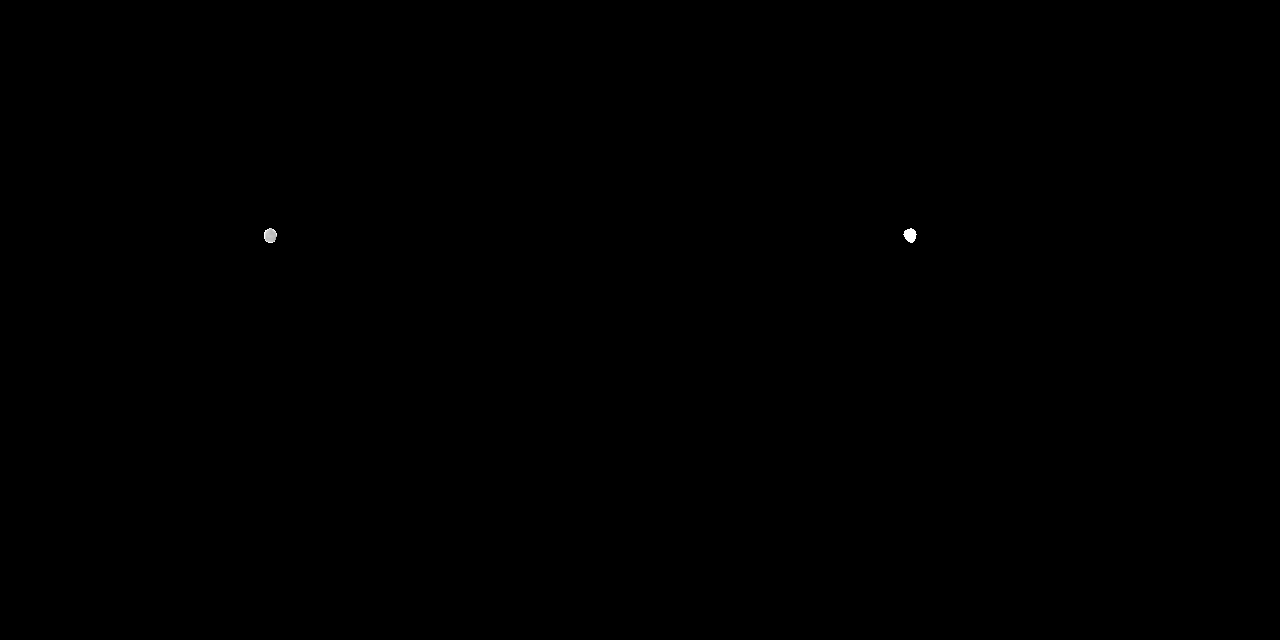

In [52]:
from random import randint
idx = randint(0,len(curr_dataset)-1)
print(idx)

decoder_input, (gt_mask, gt_masks), (input_size,original_size) = curr_dataset[idx]
low_res_masks, iou_predictions = mask_decoder(**decoder_input)

upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

# gt_binary_mask = torch.from_numpy(det_mask.astype(np.float32)).to(device)
# gt_binary_mask = get_gt_mask(gt_mask,gt_masks,binary_mask)
gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_mask,gt_masks,binary_masks)

binary_mask = binary_masks[torch.argmax(iou_predictions).item()]

# binary_mask = binary_masks[0]
from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

with torch.no_grad():
    flat_binary_mask = binary_mask.view(1,-1)
    flat_gt_binary_mask = gt_binary_mask.view(1,-1)

    focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
    dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    loss = focal_loss + dice_loss
    print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

def mask_to_img(mask):
    return Image.fromarray(mask.cpu().detach().numpy().astype(float) * 255).convert('RGB')

def clip_together_imgs(img1,img2):
    return Image.fromarray(np.hstack((img1,img2))).convert('RGB')

clip_together_imgs(mask_to_img(binary_mask),mask_to_img(gt_binary_mask))


In [54]:
from segment_anything import SamAutomaticMaskGenerator
from persam.load import load_predictor

model = load_predictor("vit_t").model.cuda()
# model.mask_decoder = mask_decoder

img = cv2.imread("demo-img.png")#list(climbing_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.1,min_mask_region_area=0,pred_iou_thresh=0)
sam_result = mask_generator.generate(img)

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

No detections found


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<IPython.core.display.HTML object>


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


: 

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(climbing_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

[]